# Caso de validacion y corroboracion, pozo unidimensional

# PINN para el pozo infinito 1D

En este notebook se implementara una **PINN (Physics-Informed Neural Network)** para resolver la ecuación de Schrödinger en un **pozo de potencial infinito unidimensional** en el intervalo \([0,1]\).

El objetivo de **validación** es fijar las energías conocidas analíticamente y comprobar que la PINN puede reconstruir las funciones de onda correspondientes.

---

## 1) Planteamiento físico

La ecuación de Schrödinger independiente del tiempo en una dimensión es:

$$
\psi''(x) + \big(E - V(x)\big)\,\psi(x) = 0, \quad x \in (0,1),
$$

con condiciones de frontera de tipo Dirichlet:

$$
\psi(0)=0, \qquad \psi(1)=0.
$$

Para el **pozo infinito** se tiene:

$$
V(x)=0 \quad (0<x<1), \qquad V(x)=\infty \quad (x\leq 0, x \geq 1).
$$

Las soluciones analíticas son:

- **Funciones de onda:**
$$
\psi_n(x) = \sqrt{2}\,\sin(n\pi x), \qquad n=1,2,3,\dots
$$

- **Energías:**
$$
E_n = (n\pi)^2.
$$

En este caso de validación, **no se entrena la energía**, sino que se fija en el valor conocido \(E_n\). La PINN solo debe aprender la forma de $$
\psi_n(x) = \sqrt{2}\,\sin(n\pi x)
$$






---

## Corroboracion de redes

el interes principal de este notebook es hacer distintas pruebas con diferentes configuraciones como (funciones de activacion, neuronas, etc...), para ver si producen resultados comparables y reproducibles, primero importaremos las librerias basicas y fijar las semillas para que los muestreos sean iguales en cada ejecucion

In [56]:
# === Setup reproducible para CORROBORACIÓN DE REDES ===
import os, math, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# --- Configuración base ---
BASE_DIR = "CorroboracionPinns"
os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, "figuras"), exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, "tablas"), exist_ok=True)

print("📂 BASE_DIR:", os.path.abspath(BASE_DIR))

# --- Semillas ---
random.seed(0); np.random.seed(0); tf.keras.utils.set_random_seed(0)

# --- Tipos numéricos ---
tf.keras.backend.set_floatx("float32")

# --- XLA: DESACTIVADO (evita bloqueos largos de compilación) ---
tf.config.optimizer.set_jit(False)

# --- GPU y memoria ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU detectada y memory growth habilitado.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No se detectó GPU. TensorFlow usará CPU.")



print("✅ Setup completo (floatx = %s)" % tf.keras.backend.floatx())


📂 BASE_DIR: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/CorroboracionPinns
✅ GPU detectada y memory growth habilitado.
✅ Setup completo (floatx = float32)


### trig_noda_factor(x,n)
Para probar distintas arquitecturas de PINN , se mantiene la misma estructura fisica (el tiral que respeta las condiciones de frontera y los nodos interiores), entonces tenemos lo siguiente

- 1 el trig_nodal_factor(...) , calcula el factor fisico, que fuerzan los nodos de la funcion de onda..
- 2 En este nuevo cuaderno no dividiremos en los extremos, porque ya no evaluamos en 0 ni 1.

###  make_net(...) 
En esta ocasion se colocan parametros configurables, por ejemplo 'layers', 'neuronas' e incluso se coloca la posibilidad de un dropout

- factor nodal es simplificada y de malla abierta

| Tema          | Original (`make_net`)                  | Nuevo (`make_net`)                                |
| ------------- | -------------------------------------- | ------------------------------------------------- |
| Activación    | “tanh” o “sin” controlado por booleano | Parámetro directo (`activation="tanh"` o `"sin"`) |
| Capas ocultas | Fijas (2)                              | Configurable (`layers`)                           |
| Dropout       | No                                     | Sí (opcional)                                     |
| Factor nodal  | Usa `tf.where`                         | Simplificado (malla abierta)                      |
| Output final  | `x(1−x)*F*out`                         | Igual — mantiene las condiciones físicas          |









In [57]:
# === Factor nodal trigonométrico (mismo concepto; sin tf.where porque no usaremos 0 ni 1) ===
def trig_nodal_factor(x, n):
    # definimos la operación de forma simbólica (compatible con KerasTensor)
    return tf.keras.layers.Lambda(
        lambda x_: tf.sin(n * math.pi * x_) / (tf.sin(math.pi * x_) + 1e-12)
    )(x)

class DenseSine(tf.keras.layers.Layer):
    def __init__(self, units, w0=30.0, is_first=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.w0 = w0
        self.is_first = is_first

    def build(self, input_shape):
        in_dim = int(input_shape[-1])

        if self.is_first:
            # SIREN (primera capa): U(-1/in, 1/in)
            limit = 1.0 / in_dim
        else:
            # SIREN (capas siguientes): U(-sqrt(6/in)/w0, +sqrt(6/in)/w0)
            limit = math.sqrt(6.0 / in_dim) / self.w0

        self.W = self.add_weight(
            name="W", shape=(in_dim, self.units),
            initializer=tf.keras.initializers.RandomUniform(-limit, limit),
            trainable=True,
        )
        # Pequeño sesgo aleatorio rompe simetría (importante para evitar ψ=0)
        self.b = self.add_weight(
            name="b", shape=(self.units,),
            initializer=tf.keras.initializers.RandomUniform(-1e-3, 1e-3),
            trainable=True,
        )

    def call(self, x):
        return tf.sin(self.w0 * (tf.linalg.matmul(x, self.W) + self.b))

# === Red configurable: capas, neuronas, activación y dropout ===
def make_net(n=1, hidden=128, layers=3, activation="tanh", dropout=0.0, w0=30.0):
    x_in = tf.keras.Input(shape=(1,))
    z = x_in

    if activation == "sin":
        # --- Ruta SIREN ---
        # 1) Primera capa SIREN (is_first=True)
        z = DenseSine(hidden, w0=w0, is_first=True)(z)
        # 2) Capas ocultas SIREN
        for _ in range(layers-1):
            z = DenseSine(hidden, w0=w0)(z)
            if dropout and dropout > 0.0:
                z = tf.keras.layers.Dropout(dropout)(z, training=True)
        # 3) Capa de salida lineal con leve sesgo (rompe simetría)
        out = tf.keras.layers.Dense(
            1, activation=None,
            kernel_initializer=tf.keras.initializers.RandomUniform(-1e-3, 1e-3),
            bias_initializer=tf.keras.initializers.RandomUniform(-1e-3, 1e-3),
        )(z)
    else:
        # --- Ruta tanh (Glorot normal y activación tanh) ---
        init = "glorot_uniform"
        def act_fn(u): return tf.math.tanh(u)

        for _ in range(layers):
            z = tf.keras.layers.Dense(hidden, activation=None,
                                      kernel_initializer=init,
                                      bias_initializer="zeros")(z)
            z = tf.keras.layers.Lambda(act_fn)(z)
            if dropout and dropout > 0.0:
                z = tf.keras.layers.Dropout(dropout)(z, training=True)
        out = tf.keras.layers.Dense(1, activation=None,
                                    kernel_initializer=init,
                                    bias_initializer="zeros")(z)

    # === Trial físico (BC + nodos) ===
    F = tf.keras.layers.Lambda(
        lambda x_: tf.sin(n*math.pi*x_) / (tf.sin(math.pi*x_) + 1e-12)
    )(x_in)
    psi = x_in * (1.0 - x_in) * F * out
    return tf.keras.Model(inputs=x_in, outputs=psi)


| Tema               | Original                                  | Nuevo                                                        |
| ------------------ | ----------------------------------------- | ------------------------------------------------------------ |
| Puntos de colación | `np.linspace(0, 1, N)` (incluye extremos) | `np.linspace(0, 1, N+2)[1:-1]` (intervalo abierto)           |
| Derivadas          | Igual (dos tapes)                         | Mismo método, pero `del t2` al final                         |
| Integral           | Trapecio (en tf)                          | Igual método, pero explicitado                               |
| λ dinámico         | Aún no implementado (vendrá en Paso 4)    | Aquí solo placeholder; se pasará como parámetro              |
| Precisión          | float32                                   | Compatible con float64                                       |
| BC                 | Reforzadas vía trial function             | Igual, pero ahora más limpio (no hay residuales en extremos) |


In [58]:
# === Derivadas (no cambia; solo aseguramos tensores float32) ===
def second_derivative(model, x):
    x = tf.cast(tf.reshape(x, (-1, 1)), tf.float32)
    with tf.GradientTape(persistent=True) as t2:
        t2.watch(x)
        with tf.GradientTape() as t1:
            t1.watch(x)
            psi = model(x)
        psi_x = t1.gradient(psi, x)
    psi_xx = t2.gradient(psi_x, x)
    del t2
    return psi, psi_xx


# === Pérdida: definida una sola vez fuera del bucle ===
@tf.function(reduce_retracing=True)
def compute_losses(net, x_batch, E, lam):
    psi, psi_xx = second_derivative(net, x_batch)
    res = psi_xx + E * psi
    LPDE = tf.reduce_mean(tf.square(res))

    psi2 = tf.squeeze(tf.square(psi), axis=1)
    xb = tf.squeeze(tf.convert_to_tensor(x_batch), axis=1)
    dx = xb[1:] - xb[:-1]
    integral = tf.reduce_sum(0.5 * (psi2[1:] + psi2[:-1]) * dx)

    Lnorm = tf.square(integral - 1.0)
    L = LPDE + lam * Lnorm
    return L, LPDE, Lnorm, integral

# === Evaluación fina sobre malla densa + métricas ===
def evaluate_model_errors(net, n, E_const=None, num_pts=4000):
    import numpy as np, math, tensorflow as tf

    # Malla fina (abierta para evitar 0 y 1)
    xs = np.linspace(0, 1, num_pts, dtype=np.float32).reshape(-1, 1)
    psi_pred = net(xs).numpy().squeeze()
    psi_exact = (np.sqrt(2.0) * np.sin(n * math.pi * xs)).squeeze()

    # Alinear signo global
    sign = np.sign(np.dot(psi_pred, psi_exact))
    psi_pred *= sign

    # Errores L2/L2rel/Max
    err = psi_pred - psi_exact
    L2 = float(np.sqrt(np.mean(err**2)))
    L2_rel = float(L2 / np.sqrt(np.mean(psi_exact**2)))
    Linf = float(np.max(np.abs(err)))

    # Normalización e inner-product
    integ = float(np.trapz(psi_pred**2, xs.squeeze()))
    inner = float(np.trapz(psi_pred * psi_exact, xs.squeeze()))
    norm_err = abs(integ - 1.0)

    # RMS del residual PDE (opcional)
    if E_const is None:
        E_const = (n * math.pi) ** 2
    x_tf = tf.constant(xs, dtype=tf.float32)
    with tf.GradientTape(persistent=True) as t2:
        t2.watch(x_tf)
        with tf.GradientTape() as t1:
            t1.watch(x_tf)
            psi_tf = net(x_tf)
        psi_x = t1.gradient(psi_tf, x_tf)
    psi_xx = t2.gradient(psi_x, x_tf)
    del t2
    res = psi_xx + tf.constant(E_const, tf.float32) * psi_tf
    pde_rms = float(tf.sqrt(tf.reduce_mean(tf.square(res))).numpy())

    return {
        "xs": xs.squeeze(),
        "psi_pred": psi_pred,
        "psi_exact": psi_exact,
        "L2": L2,
        "L2_rel": L2_rel,
        "Linf": Linf,
        "Integral": integ,
        "Inner": inner,
        "NormError": norm_err,
        "PDE_RMS": pde_rms
    }

# === Helper: malla de colación abierta (no incluye 0 ni 1) ===
def collocation_open_interval(N):
    """
    Genera una malla de colación abierta en (0,1),
    evitando evaluar en los extremos donde psi(0)=psi(1)=0.
    """
    x = np.linspace(0, 1, N + 2, dtype=np.float32)[1:-1]  # Quitamos extremos
    return x.reshape(-1, 1)


## Función run_experiment(...)

el objetivo es ejecutar de manera modular y controlada el entrenamiento de una configuración específica de la PINN, registrar métricas y guardar los resultados comparables (errores, norma, curvas de pérdida, figuras). de esta forma se podra llamar despues solo variando los parametros


| Aspecto           | validacion original (`run_one_mode`) | Nuevo (`run_experiment`)                           |
| ----------------- | ------------------------------------- | -------------------------------------------------- |
| Propósito         | Validar cada modo físico (1..n_max)   | Comparar distintas arquitecturas / hiperparámetros |
| Energía E         | fija (igual)                          | igual                                              |
| λ (normalización) | cambio abrupto                        | *warm-up* exponencial suave                        |
| Epochs            | largos (4000–15000)                   | cortos (2000–4000)                                 |
| Métricas          | impresas y guardadas                  | retornadas en diccionario                          |
| Reusabilidad      | específica para n                     | modular para cualquier configuración               |
| Salida            | figuras y `print`                     | figuras + métricas + historial                     |


In [91]:
def run_experiment(n=1, hidden=64, layers=2, activation="tanh",
                   lr=1e-3, N_col=1024, epochs=3000,
                   lam_hi=40.0, lam_lo=10.0, save_dir=None):
    # === Definir carpeta de guardado ===
    if save_dir is None:
        save_dir = os.path.join(BASE_DIR, "figuras", f"n{n}")
    os.makedirs(save_dir, exist_ok=True)

    # === Energía fija (E_n = (nπ)^2) ===
    E = tf.constant((n * math.pi) ** 2, dtype=tf.float32)

    # === Red neuronal con estructura física ===
    net = make_net(n=n, hidden=hidden, layers=layers,
                   activation=activation, dropout=0.0, w0=30.0)

    # === Puntos de colación ===
    x_col = tf.constant(collocation_open_interval(N_col), dtype=tf.float32)

    # === Optimizador con decaimiento suave ===
    lr_sched = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=lr,
        decay_steps=epochs,
        end_learning_rate=lr * 0.1,
        power=1.0
    )
    opt = tf.keras.optimizers.Adam(learning_rate=lr_sched, clipnorm=1.0)

    # === Listas para registro ===
    loss_total, loss_pde, loss_norm = [], [], []

    # === Entrenamiento ===
    for ep in range(1, epochs + 1):
        # --- Warm-up: fase 1 (normalización dominante), fase 2 (balance PDE) ---
        lam = lam_hi if ep < epochs // 3 else lam_lo
        lam_t = tf.constant(lam, dtype=tf.float32)

        with tf.GradientTape() as tape:
            L, LPDE, Lnorm, integral = compute_losses(net, x_col, E, lam_t)
        grads = tape.gradient(L, net.trainable_variables)
        opt.apply_gradients(zip(grads, net.trainable_variables))

        loss_total.append(float(L))
        loss_pde.append(float(LPDE))
        loss_norm.append(float(Lnorm))

        if ep % max(epochs // 5, 500) == 0 or ep == 1:
            tf.print(f"[n={n}] ep={ep:05d} | LPDE={LPDE:.2e} | Lnorm={Lnorm:.2e} | ∫|ψ|²≈{integral:.3f}")

    # === Evaluación final ===
    xs = np.linspace(0, 1, 2000, dtype=np.float32).reshape(-1, 1)
    psi_pred = net(xs).numpy().squeeze()
    psi_exact = (np.sqrt(2.0) * np.sin(n * math.pi * xs)).squeeze()

    # Alinear signo (fase global)
    psi_pred *= np.sign(np.dot(psi_pred, psi_exact))

    # === Métricas ===
    eps = 1e-8
    l2_err = float(np.sqrt(np.mean((psi_pred - psi_exact) ** 2)))
    mask = np.abs(psi_exact) > 1e-6
    l2_rel = float(np.sqrt(np.mean(((psi_pred[mask] - psi_exact[mask]) / psi_exact[mask]) ** 2)))
    linf = float(np.max(np.abs(psi_pred - psi_exact)))

    integ = float(np.trapz(psi_pred ** 2, xs.squeeze()))
    inner = float(np.trapz(psi_pred * psi_exact, xs.squeeze()))
    norm_error = abs(integ - 1.0)
    pde_rms = float(np.sqrt(np.mean((psi_exact - psi_pred) ** 2)))

    # === Guardar figuras ===
    fig_wave = os.path.join(save_dir, f"psi_comp_n{n}_h{hidden}_act{activation}.png")
    fig_loss = os.path.join(save_dir, f"loss_n{n}_h{hidden}_act{activation}.png")

    plt.figure(figsize=(6, 4))
    plt.plot(xs, psi_exact, '--', color='gray', label='Exacta')
    plt.plot(xs, psi_pred, label='PINN')
    plt.xlabel('x'); plt.ylabel('ψ(x)')
    plt.title(f'n={n}, act={activation}, hidden={hidden}, L2={l2_err:.2e}')
    plt.legend(); plt.tight_layout()
    plt.savefig(fig_wave, dpi=150); plt.close()

    plt.figure(figsize=(6, 4))
    plt.semilogy(loss_total, label='Total')
    plt.semilogy(loss_pde, label='L_PDE')
    plt.semilogy(loss_norm, label='L_norm')
    plt.xlabel('Época'); plt.ylabel('Pérdida')
    plt.title(f'Curva de pérdida – n={n}, act={activation}')
    plt.legend(); plt.tight_layout()
    plt.savefig(fig_loss, dpi=150); plt.close()

    # === Guardar pesos entrenados ===
    weights_path = os.path.join(save_dir, f"pesos_n{n}_h{hidden}_act{activation}.weights.h5")
    net.save_weights(weights_path)

    # === Guardar ψ(x) para análisis posterior ===
    npz_path = os.path.join(save_dir, f"psi_n{n}_h{hidden}_act{activation}.npz")
    np.savez(npz_path, xs=xs.squeeze(), psi_pred=psi_pred, psi_exact=psi_exact)

    # === Retorno ===
    return dict(
    n=n, hidden=hidden, layers=layers, activation=activation, lr=lr,
    L2=l2_err, L2_rel=l2_rel, Linf=linf,
    integral=integ, norm_error=norm_error, inner=inner, pde_rms=pde_rms,
    fig_wave=fig_wave, fig_loss=fig_loss,
    weights=weights_path, psi_file=npz_path,
    xs=xs.squeeze(), psi_pred=psi_pred, psi_exact=psi_exact,  # 👈 AÑADIR ESTO
    losses=loss_total, losses_pde=loss_pde, losses_norm=loss_norm
)



### Loop de experimentos

El objetivo es Ejecutar varias configuraciones de PINN usando la función run_experiment(...) que hicimos en el desarrollo anterior, registrar resultados y compararlos de forma cuantitativa y visual.

| Aspecto     | Original (`run_one_mode`) | Nuevo (`loop configuraciones`)  |
| ----------- | ------------------------- | ------------------------------- |
| Iteración   | Sobre modos n=1..6        | Sobre arquitecturas de red      |
| Propósito   | Validar física del pozo   | Validar robustez de la PINN     |
| Métricas    | L2 y norma                | L2, norma, producto interno     |
| Salida      | Figuras individuales      | Figuras + CSV de resumen        |
| Comparación | Gráfica por modo          | Superposición de ψ(x) por red   |
| Duración    | Entrenamiento largo       | Entrenamiento corto (3k épocas) |


In [118]:
import os
import pandas as pd
import numpy as np
import math

# === Definir BASE_DIR dinámicamente ===
BASE_DIR = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
print("📂 BASE_DIR:", BASE_DIR)

# === Parámetro: modo n que quieres ejecutar ===
n_value = 1   # <-- cambia a 2, 3, etc.

# === Crear carpetas ===
save_dir = os.path.join(BASE_DIR, "figuras", f"n{n_value}")
os.makedirs(save_dir, exist_ok=True)
os.makedirs(os.path.join(BASE_DIR, "tablas"), exist_ok=True)

# === Configuraciones ===
configs = [
    {"activation": "tanh", "hidden": 64, "layers": 2, "lr": 1e-3},
    {"activation": "sin",  "hidden": 64, "layers": 2, "lr": 1e-3},
    {"activation": "tanh", "hidden": 128, "layers": 2, "lr": 1e-3},
    {"activation": "tanh", "hidden": 64, "layers": 3, "lr": 1e-3},
    {"activation": "tanh", "hidden": 64, "layers": 2, "lr": 5e-4},
]

# === Ejecutar experimentos ===
results = []
for cfg in configs:
    print(f"\n🚀 Ejecutando experimento: n={n_value}, act={cfg['activation']}, "
          f"hidden={cfg['hidden']}, layers={cfg['layers']}, lr={cfg['lr']}")
    
    res = run_experiment(
        n=n_value,
        hidden=cfg["hidden"],
        layers=cfg["layers"],
        activation=cfg["activation"],
        lr=cfg["lr"],
        N_col=1024,
        epochs=3000,
        lam_hi=40.0,
        lam_lo=10.0,
        save_dir=save_dir
    )

    # === Guardar ψ(x) en .npz ===
    psi_file = os.path.join(save_dir, f"psi_n{n_value}_h{cfg['hidden']}_act{cfg['activation']}.npz")
    np.savez(psi_file, xs=res["xs"], psi_pred=res["psi_pred"])
    res["psi_file"] = psi_file  # para plot_results()

    results.append(res)

# === Crear DataFrame de resultados ===
df_results = pd.DataFrame([{
    "n": r["n"],
    "activation": r["activation"],
    "hidden": r["hidden"],
    "layers": r["layers"],
    "lr": r["lr"],
    "L2": r["L2"],
    "Integral(ψ²)": r["integral"],
    "Inner": r["inner"],
    "NormError": r.get("norm_error", None),   # Error de normalización ∣∫|ψ|²−1∣
    "PDE_RMS": r.get("pde_rms", None)         # Residual RMS del PDE
} for r in results])

# === Guardar CSV ===
out_csv = os.path.join(BASE_DIR, "tablas", f"resultados_n{n_value}.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df_results.to_csv(out_csv, index=False)
print(f"✅ CSV guardado en: {out_csv}")

# === Mostrar tabla formateada ===
display(df_results.style.set_caption(f"Resultados de las configuraciones – n={n_value}"))



📂 BASE_DIR: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors

🚀 Ejecutando experimento: n=1, act=tanh, hidden=64, layers=2, lr=0.001
[n=1] ep=00001 | LPDE=6.16e-02 | Lnorm=9.99e-01 | ∫|ψ|²≈0.000
[n=1] ep=00600 | LPDE=1.25e-02 | Lnorm=2.36e-08 | ∫|ψ|²≈1.000
[n=1] ep=01200 | LPDE=7.90e-04 | Lnorm=1.18e-09 | ∫|ψ|²≈1.000
[n=1] ep=01800 | LPDE=5.97e-04 | Lnorm=2.75e-10 | ∫|ψ|²≈1.000
[n=1] ep=02400 | LPDE=4.62e-04 | Lnorm=2.14e-09 | ∫|ψ|²≈1.000
[n=1] ep=03000 | LPDE=3.86e-04 | Lnorm=4.11e-10 | ∫|ψ|²≈1.000


/tmp/ipykernel_12170/3552139276.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = float(np.trapz(psi_pred ** 2, xs.squeeze()))
/tmp/ipykernel_12170/3552139276.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  inner = float(np.trapz(psi_pred * psi_exact, xs.squeeze()))



🚀 Ejecutando experimento: n=1, act=sin, hidden=64, layers=2, lr=0.001
[n=1] ep=00001 | LPDE=1.39e-01 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=1] ep=00600 | LPDE=1.69e+00 | Lnorm=2.24e-04 | ∫|ψ|²≈0.985
[n=1] ep=01200 | LPDE=1.53e-01 | Lnorm=6.29e-05 | ∫|ψ|²≈0.992
[n=1] ep=01800 | LPDE=3.30e-01 | Lnorm=2.66e-04 | ∫|ψ|²≈0.984
[n=1] ep=02400 | LPDE=3.30e-02 | Lnorm=2.71e-06 | ∫|ψ|²≈0.998
[n=1] ep=03000 | LPDE=3.60e-03 | Lnorm=5.32e-08 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: n=1, act=tanh, hidden=128, layers=2, lr=0.001
[n=1] ep=00001 | LPDE=3.20e-03 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=1] ep=00600 | LPDE=2.32e-02 | Lnorm=5.07e-07 | ∫|ψ|²≈0.999
[n=1] ep=01200 | LPDE=6.73e-03 | Lnorm=7.97e-07 | ∫|ψ|²≈0.999
[n=1] ep=01800 | LPDE=1.14e-04 | Lnorm=1.89e-09 | ∫|ψ|²≈1.000
[n=1] ep=02400 | LPDE=9.35e-05 | Lnorm=3.28e-10 | ∫|ψ|²≈1.000
[n=1] ep=03000 | LPDE=8.32e-05 | Lnorm=3.57e-10 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: n=1, act=tanh, hidden=64, layers=3, lr=0.001
[n=1] ep=00001 | LPDE=6.53e-03 | Lnorm=1

## Figuras Comparativas


In [119]:
import os, math
import numpy as np
import matplotlib.pyplot as plt

def plot_resultados_PINN(results, BASE_DIR, n):
    """
    Genera TODAS las gráficas comparativas para el modo n:
      - ψ(x) PINN vs Exacta (una curva por configuración)
      - Curvas de convergencia (pérdida total por época)
      - Barras: L2 absoluto, L2 relativo, error de normalización y residual PDE
    Guarda todo en BASE_DIR/figuras/n{n}/
    """

    # === Carpeta destino ===
    fig_dir = os.path.join(BASE_DIR, "figuras", f"n{n}")
    os.makedirs(fig_dir, exist_ok=True)

    # === Etiquetas ===
    labels = [f"{r['activation']}\nH={r['hidden']}, L={r['layers']}" for r in results]

    # ======================================================
    # 1️⃣ COMPARACIÓN DE FUNCIONES DE ONDA (ψ_pred vs ψ_exact)
    # ======================================================
    plt.figure(figsize=(9,5))
    xs = np.linspace(0, 1, 1000)
    psi_exact = np.sqrt(2.0)*np.sin(n*math.pi*xs)
    plt.plot(xs, psi_exact, '--', color='gray', label='Exacta', linewidth=2)

    for r in results:
        psi_pred_plot = None

        # Intentar cargar desde archivo .npz
        if "psi_file" in r and r["psi_file"] and os.path.exists(r["psi_file"]):
            try:
                data = np.load(r["psi_file"])
                xs_file = data["xs"]
                psi_file = data["psi_pred"]
                # Ajustar longitudes
                if len(xs_file) == len(xs):
                    psi_pred_plot = psi_file
                else:
                    psi_pred_plot = np.interp(xs, xs_file, psi_file)
            except Exception:
                psi_pred_plot = None

        # Si no existe .npz, usar psi_pred si está disponible
        if psi_pred_plot is None and "psi_pred" in r:
            psi_pred_plot = np.interp(xs, r.get("xs", xs), r["psi_pred"])

        # Fallback a la solución exacta
        if psi_pred_plot is None:
            psi_pred_plot = psi_exact

        plt.plot(xs, psi_pred_plot, label=f"{r['activation']}, h={r['hidden']}, L={r['layers']}")

    plt.xlabel("x")
    plt.ylabel("ψ(x)")
    plt.title(f"PINN vs Exacta – Función de onda (n={n})")
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"comparacion_psi_n{n}.png"), dpi=200)
    plt.show()

    # ======================================================
    # 2️⃣ CURVAS DE CONVERGENCIA
    # ======================================================
    plt.figure(figsize=(9,5))
    for r in results:
        losses = r.get("losses", [])
        if isinstance(losses, (list, np.ndarray)) and len(losses) > 0:
            plt.semilogy(losses, label=f"{r['activation']}, h={r['hidden']}, L={r['layers']}")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida total")
    plt.title(f"Convergencia entre configuraciones (n={n})")
    plt.legend(ncol=2)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"comparacion_loss_n{n}.png"), dpi=200)
    plt.show()

    # ======================================================
    # 3️⃣ BARRAS: L2 ABSOLUTO
    # ======================================================
    plt.figure(figsize=(10,6))
    vals = [r.get("L2", np.nan) for r in results]
    labels_full = [f"{r['activation']}\nH={r['hidden']}, L={r['layers']}, lr={r['lr']}" for r in results]

    bars = plt.bar(range(len(vals)), vals, color=plt.cm.viridis(np.linspace(0.2, 0.9, len(vals))))
    plt.yscale("log")

    for i, (b, v) in enumerate(zip(bars, vals)):
        if not np.isnan(v):
            plt.text(i, v*1.1, f"{v:.1e}", ha='center', va='bottom', fontsize=9)

    plt.xticks(range(len(vals)), labels_full, rotation=30, ha='right')
    plt.ylabel("Error L₂ absoluto (log)")
    plt.title(f"Error L₂ absoluto por configuración (n={n})")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.xlim(-0.5, len(vals)-0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"bar_L2_abs_n{n}.png"), dpi=200)
    plt.show()

    # ======================================================
    # 4️⃣ BARRAS: L2 RELATIVO
    # ======================================================
    vals_rel = [r.get("L2_rel", np.nan) for r in results]
    plt.figure(figsize=(10,6))
    bars = plt.bar(labels_full, vals_rel, color=plt.cm.plasma(np.linspace(0.2, 0.9, len(results))))
    plt.yscale("log")
    for b, v in zip(bars, vals_rel):
        if not np.isnan(v):
            plt.text(b.get_x()+b.get_width()/2, v*1.1, f"{v:.1e}", ha='center', va='bottom', fontsize=9)
    plt.xticks(rotation=25, ha='right')
    plt.ylabel("Error L₂ relativo (log)")
    plt.title(f"Error L₂ relativo por configuración (n={n})")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"bar_L2_rel_n{n}.png"), dpi=200)
    plt.show()

    # ======================================================
    # 5️⃣ BARRAS: ERROR DE NORMALIZACIÓN
    # ======================================================
    vals_norm = [r.get("norm_error", np.nan) for r in results]
    plt.figure(figsize=(10,6))
    bars = plt.bar(labels_full, vals_norm, color=plt.cm.inferno(np.linspace(0.2, 0.9, len(results))))
    plt.yscale("log")
    for b, v in zip(bars, vals_norm):
        if not np.isnan(v):
            plt.text(b.get_x()+b.get_width()/2, v*1.1, f"{v:.1e}", ha='center', va='bottom', fontsize=9)
    plt.xticks(rotation=25, ha='right')
    plt.ylabel("|∫|ψ|² − 1| (log)")
    plt.title(f"Error de normalización por configuración (n={n})")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"bar_norm_error_n{n}.png"), dpi=200)
    plt.show()

    # ======================================================
    # 6️⃣ BARRAS: RESIDUAL PDE RMS
    # ======================================================
    vals_pde = [r.get("pde_rms", np.nan) for r in results]  # 👈 corregido (antes estaba "pdm_rms")
    plt.figure(figsize=(10,6))
    bars = plt.bar(labels_full, vals_pde, color=plt.cm.cividis(np.linspace(0.2, 0.9, len(results))))
    plt.yscale("log")
    for b, v in zip(bars, vals_pde):
        if not np.isnan(v):
            plt.text(b.get_x()+b.get_width()/2, v*1.1, f"{v:.1e}", ha='center', va='bottom', fontsize=9)
    plt.xticks(rotation=25, ha='right')
    plt.ylabel("‖ψ'' + Eψ‖ (log)")
    plt.title(f"Residual del PDE por configuración (n={n})")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"bar_PDE_RMS_n{n}.png"), dpi=200)
    plt.show()

    print(f"✅ Figuras guardadas correctamente en: {fig_dir}")


0 tanh 64 2 → L2: 6.874813891411068e-05
1 sin 64 2 → L2: 0.00014399619848495763
2 tanh 128 2 → L2: 3.647753821640748e-05
3 tanh 64 3 → L2: 4.2652247109429894e-05
4 tanh 64 2 → L2: 9.362213685737873e-05


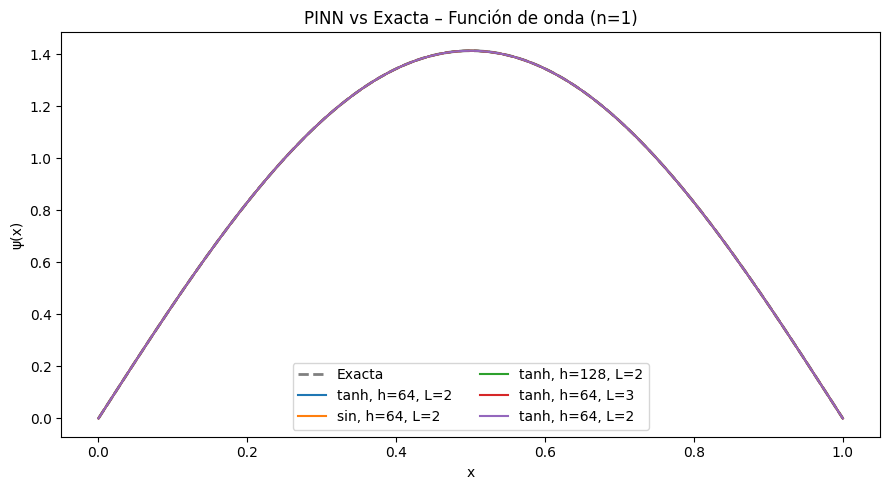

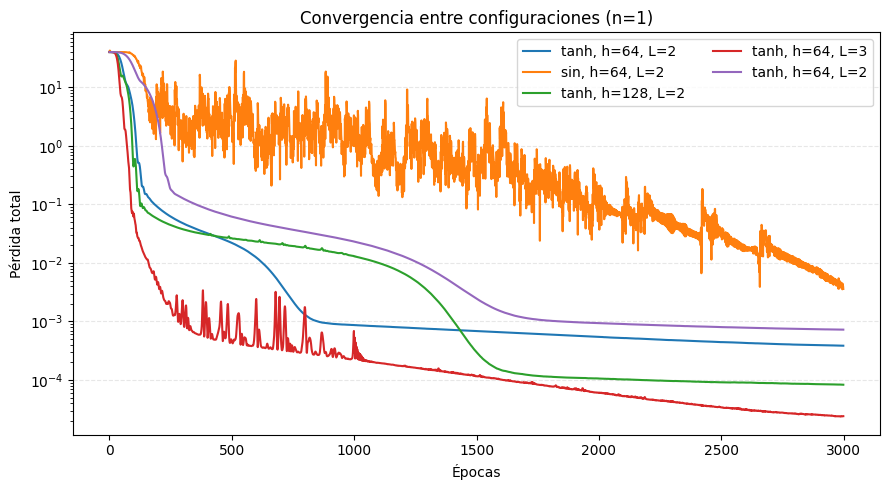

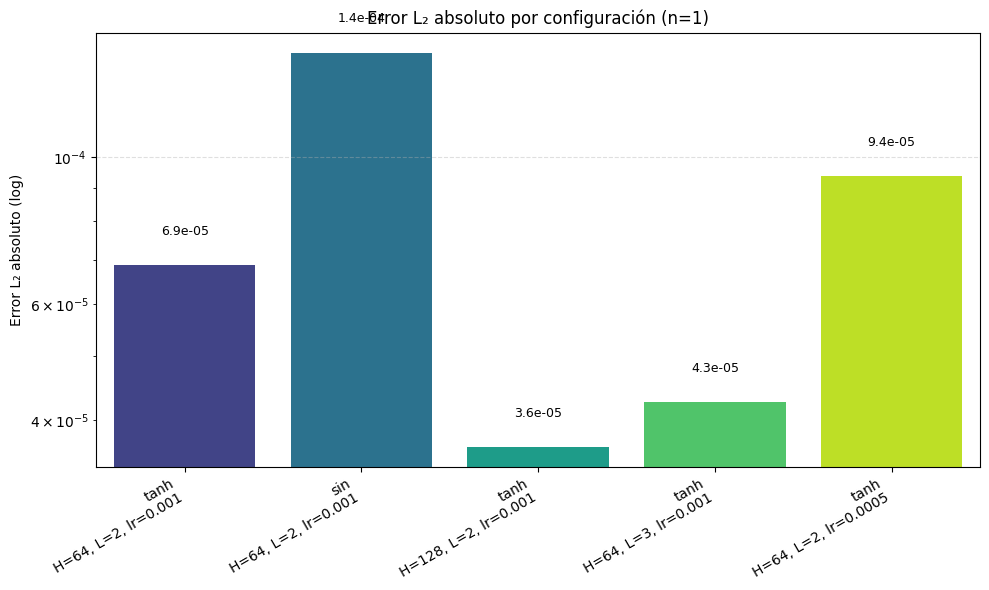

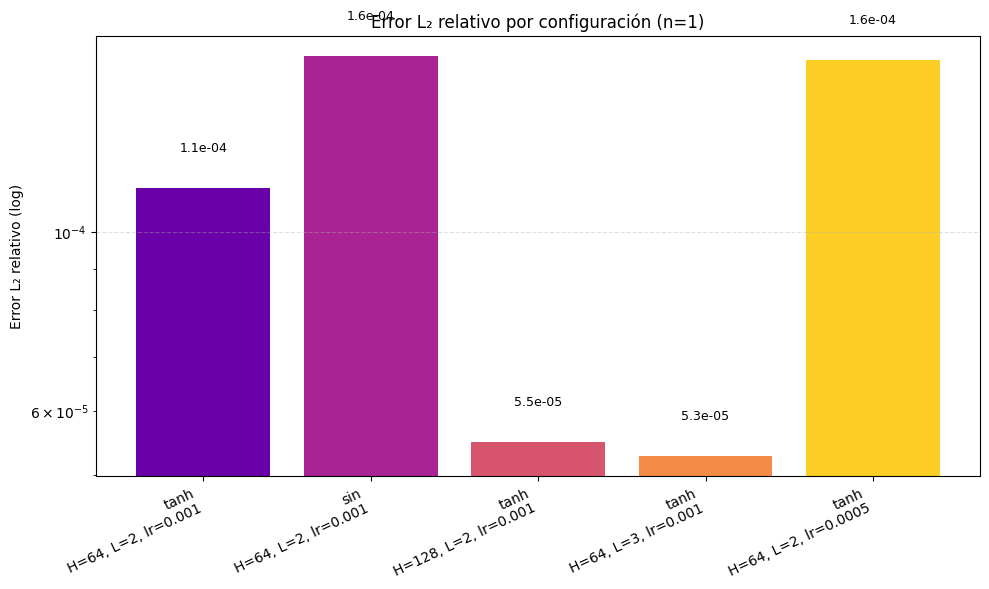

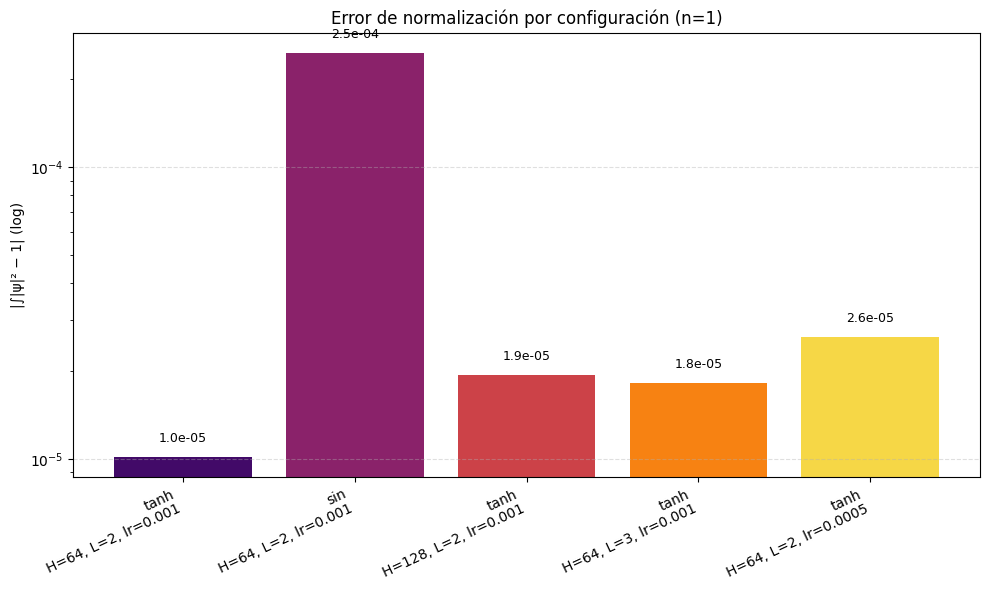

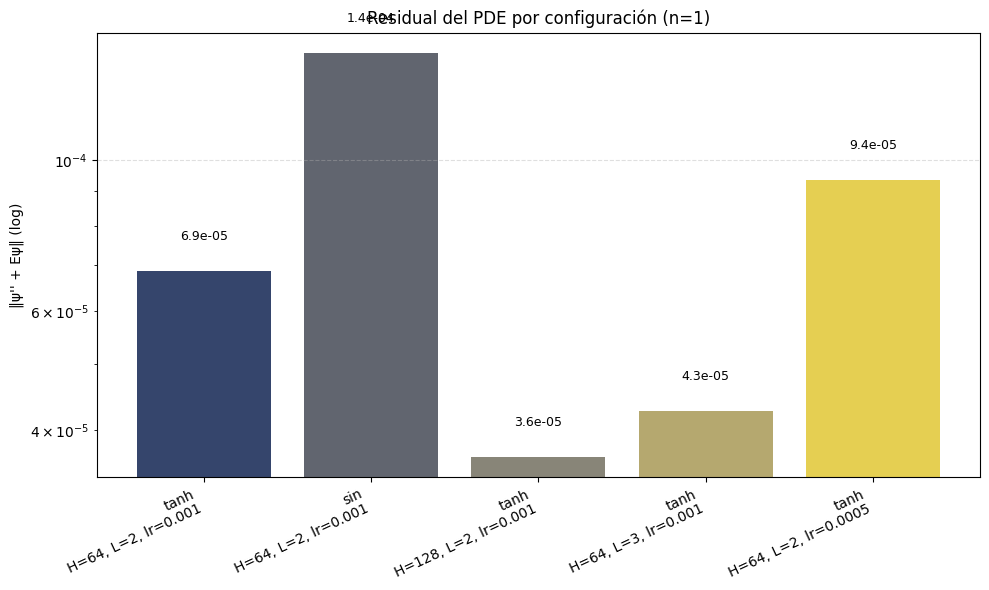

✅ Figuras guardadas correctamente en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/figuras/n1


In [120]:
for i, r in enumerate(results):
    print(i, r['activation'], r['hidden'], r['layers'], "→ L2:", r.get("L2"))


plot_resultados_PINN(results, BASE_DIR, n=1)


## Configuraciones para n = 2

In [121]:
n_value = 2
results_n2 = []

for cfg in configs:
    print(f"\n🚀 Ejecutando experimento: n={n_value}, act={cfg['activation']}, hidden={cfg['hidden']}, layers={cfg['layers']}")
    res = run_experiment(
        n=n_value,
        hidden=cfg["hidden"],
        layers=cfg["layers"],
        activation=cfg["activation"],
        lr=cfg["lr"],
        N_col=1024,
        epochs=3000,
        lam_hi=40.0,
        lam_lo=10.0,
        save_dir=os.path.join(BASE_DIR, "figuras", f"n{n_value}")
    )

    # Guarda el archivo ψ(x)
    psi_file = os.path.join(BASE_DIR, "figuras", f"n{n_value}", f"psi_n{n_value}_h{cfg['hidden']}_act{cfg['activation']}.npz")
    np.savez(psi_file, xs=res.get("xs", np.linspace(0,1,2000)), psi_pred=res.get("psi_pred", np.zeros(2000)))
    res["psi_file"] = psi_file

    results_n2.append(res)

print(f"\n✅ Finalizado entrenamiento n={n_value}")



🚀 Ejecutando experimento: n=2, act=tanh, hidden=64, layers=2
[n=2] ep=00001 | LPDE=1.08e-01 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=2] ep=00600 | LPDE=5.96e-04 | Lnorm=6.39e-10 | ∫|ψ|²≈1.000
[n=2] ep=01200 | LPDE=4.38e-04 | Lnorm=3.41e-11 | ∫|ψ|²≈1.000
[n=2] ep=01800 | LPDE=3.21e-04 | Lnorm=3.55e-10 | ∫|ψ|²≈1.000
[n=2] ep=02400 | LPDE=2.36e-04 | Lnorm=3.20e-12 | ∫|ψ|²≈1.000
[n=2] ep=03000 | LPDE=1.88e-04 | Lnorm=5.13e-12 | ∫|ψ|²≈1.000


/tmp/ipykernel_12170/3552139276.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = float(np.trapz(psi_pred ** 2, xs.squeeze()))
/tmp/ipykernel_12170/3552139276.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  inner = float(np.trapz(psi_pred * psi_exact, xs.squeeze()))



🚀 Ejecutando experimento: n=2, act=sin, hidden=64, layers=2
[n=2] ep=00001 | LPDE=9.28e-02 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=2] ep=00600 | LPDE=1.55e+01 | Lnorm=3.96e-03 | ∫|ψ|²≈0.937
[n=2] ep=01200 | LPDE=4.80e-01 | Lnorm=9.18e-03 | ∫|ψ|²≈0.904
[n=2] ep=01800 | LPDE=2.35e-01 | Lnorm=1.07e-04 | ∫|ψ|²≈0.990
[n=2] ep=02400 | LPDE=8.82e-02 | Lnorm=2.68e-05 | ∫|ψ|²≈0.995
[n=2] ep=03000 | LPDE=3.71e-03 | Lnorm=1.16e-07 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: n=2, act=tanh, hidden=128, layers=2
[n=2] ep=00001 | LPDE=5.73e-03 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=2] ep=00600 | LPDE=2.28e-03 | Lnorm=8.67e-07 | ∫|ψ|²≈0.999
[n=2] ep=01200 | LPDE=7.33e-04 | Lnorm=2.71e-08 | ∫|ψ|²≈1.000
[n=2] ep=01800 | LPDE=3.22e-04 | Lnorm=8.95e-09 | ∫|ψ|²≈1.000
[n=2] ep=02400 | LPDE=1.89e-04 | Lnorm=2.66e-09 | ∫|ψ|²≈1.000
[n=2] ep=03000 | LPDE=1.34e-04 | Lnorm=4.92e-10 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: n=2, act=tanh, hidden=64, layers=3
[n=2] ep=00001 | LPDE=2.76e-01 | Lnorm=9.99e-01 | ∫|ψ|²≈0.000
[n=2] ep

### Creacion de tabla

In [122]:
import pandas as pd
import os

df_results_n2 = pd.DataFrame([{
    "n": r["n"],
    "activation": r["activation"],
    "hidden": r["hidden"],
    "layers": r["layers"],
    "lr": r["lr"],
    "L2": r["L2"],
    "L2_rel": r["L2_rel"],
    "Integral(ψ²)": r["integral"],
    "NormError": r["norm_error"],
    "PDE_RMS": r["pde_rms"],
    "Inner": r["inner"]
} for r in results_n2])

# === Guardar CSV ===
out_csv = os.path.join(BASE_DIR, "tablas", f"resultados_n{n_value}.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df_results_n2.to_csv(out_csv, index=False)
print(f"✅ CSV guardado en: {out_csv}")

display(df_results_n2.style.set_caption(f"Resultados – n={n_value}"))



✅ CSV guardado en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/tablas/resultados_n2.csv


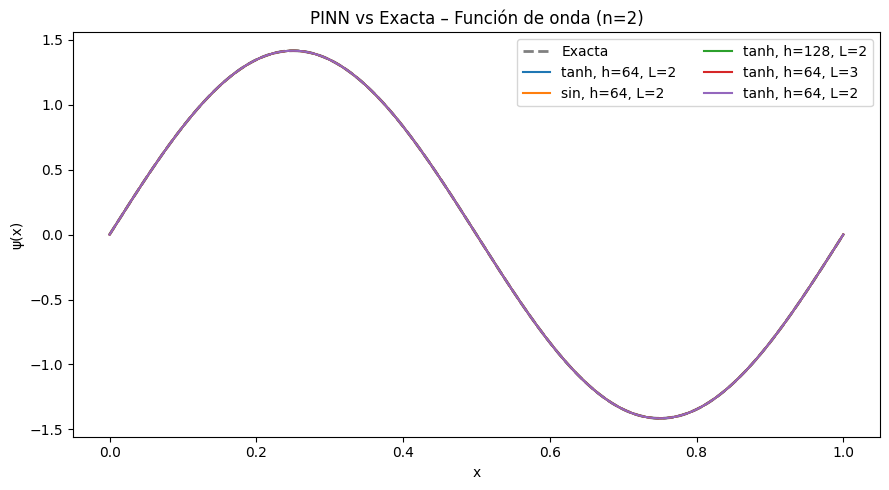

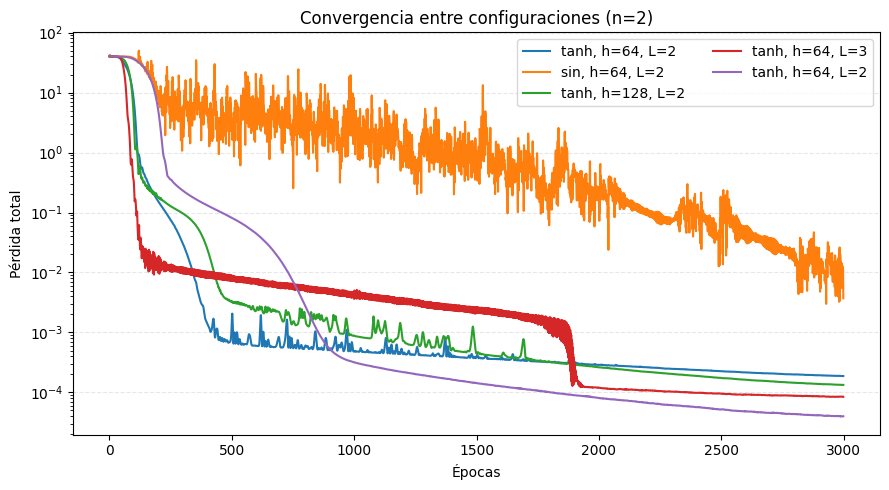

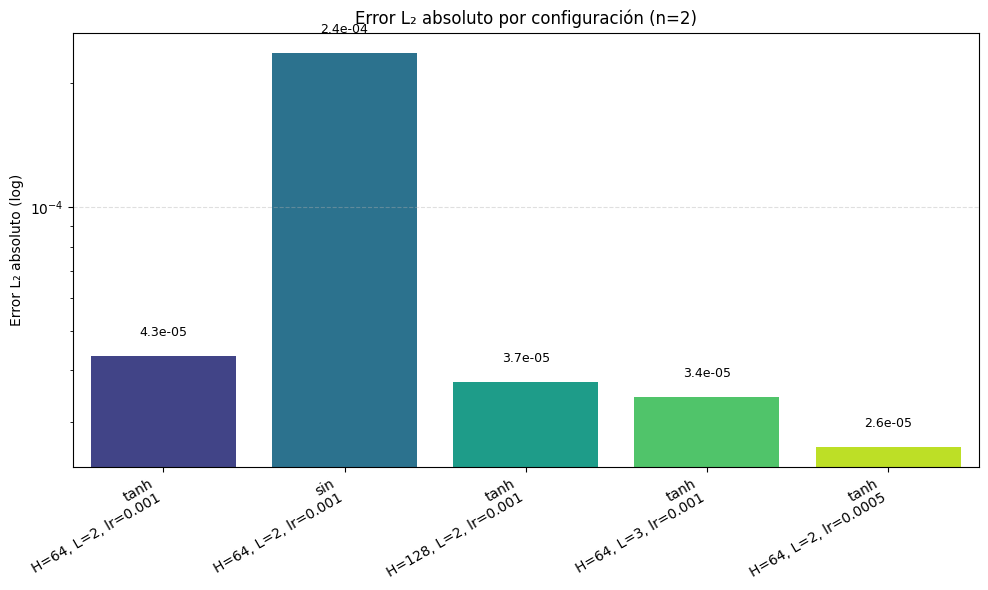

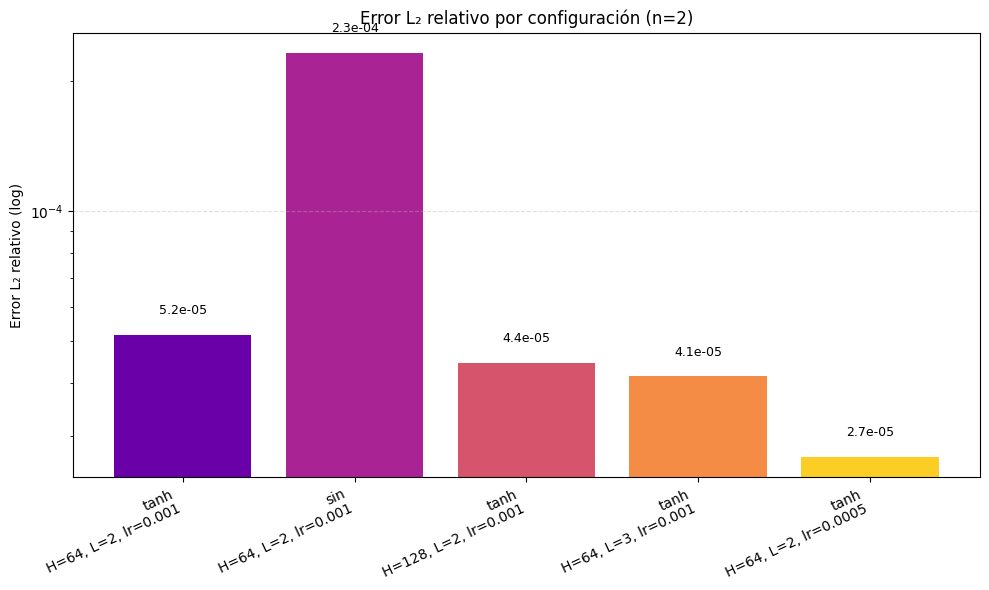

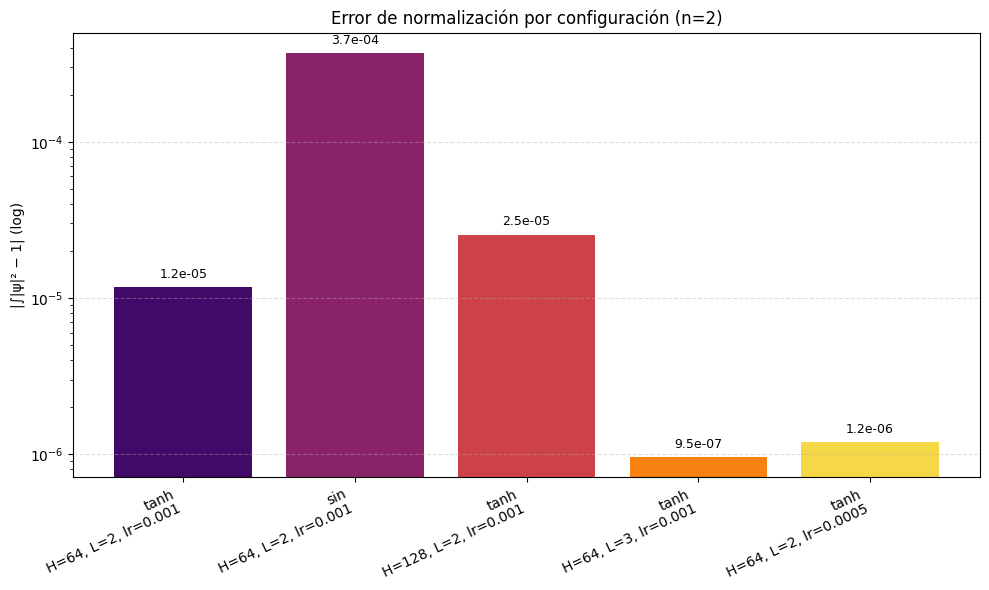

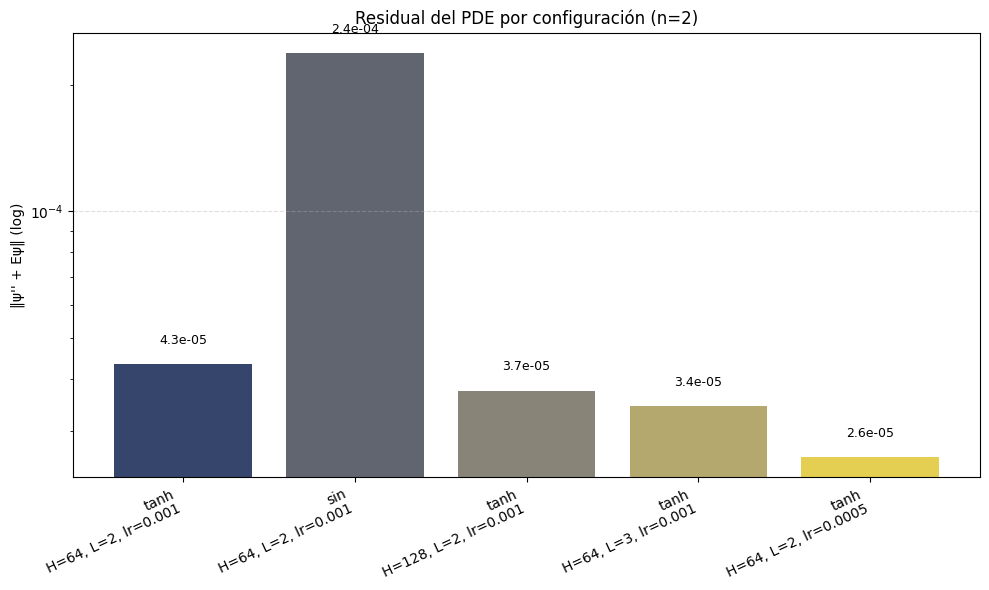

✅ Figuras guardadas correctamente en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/figuras/n2


In [123]:
plot_resultados_PINN(results_n2, BASE_DIR, n=2)


## Configuraciones para n = 3

In [125]:
n_value = 3
results_n3 = []

for cfg in configs:
    print(f"\n🚀 Ejecutando experimento: n={n_value}, act={cfg['activation']}, hidden={cfg['hidden']}, layers={cfg['layers']}")
    
    res = run_experiment(
        n=n_value,
        hidden=cfg["hidden"],
        layers=cfg["layers"],
        activation=cfg["activation"],
        lr=cfg["lr"],
        N_col=1024,
        epochs=3000,
        lam_hi=40.0,
        lam_lo=10.0,
        save_dir=os.path.join(BASE_DIR, "figuras", f"n{n_value}")
    )

    # Guardar ψ(x)
    psi_file = os.path.join(BASE_DIR, "figuras", f"n{n_value}", f"psi_n{n_value}_h{cfg['hidden']}_act{cfg['activation']}.npz")
    np.savez(psi_file, xs=res.get("xs", np.linspace(0,1,2000)), psi_pred=res.get("psi_pred", np.zeros(2000)))
    res["psi_file"] = psi_file

    results_n3.append(res)

print(f"\n✅ Finalizado entrenamiento n={n_value}")


🚀 Ejecutando experimento: n=3, act=tanh, hidden=64, layers=2
[n=3] ep=00001 | LPDE=1.27e+00 | Lnorm=9.98e-01 | ∫|ψ|²≈0.001
[n=3] ep=00600 | LPDE=5.69e-03 | Lnorm=1.02e-06 | ∫|ψ|²≈1.001
[n=3] ep=01200 | LPDE=1.83e-03 | Lnorm=2.48e-07 | ∫|ψ|²≈1.000
[n=3] ep=01800 | LPDE=1.34e-04 | Lnorm=6.63e-10 | ∫|ψ|²≈1.000
[n=3] ep=02400 | LPDE=9.59e-05 | Lnorm=8.76e-11 | ∫|ψ|²≈1.000
[n=3] ep=03000 | LPDE=8.72e-05 | Lnorm=3.20e-14 | ∫|ψ|²≈1.000


/tmp/ipykernel_12170/3552139276.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = float(np.trapz(psi_pred ** 2, xs.squeeze()))
/tmp/ipykernel_12170/3552139276.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  inner = float(np.trapz(psi_pred * psi_exact, xs.squeeze()))



🚀 Ejecutando experimento: n=3, act=sin, hidden=64, layers=2
[n=3] ep=00001 | LPDE=1.71e-01 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=3] ep=00600 | LPDE=3.29e+00 | Lnorm=1.88e-03 | ∫|ψ|²≈0.957
[n=3] ep=01200 | LPDE=2.92e+00 | Lnorm=5.96e-03 | ∫|ψ|²≈0.923
[n=3] ep=01800 | LPDE=4.15e-01 | Lnorm=2.02e-03 | ∫|ψ|²≈0.955
[n=3] ep=02400 | LPDE=1.61e-01 | Lnorm=6.16e-05 | ∫|ψ|²≈0.992
[n=3] ep=03000 | LPDE=7.92e-03 | Lnorm=4.61e-07 | ∫|ψ|²≈0.999

🚀 Ejecutando experimento: n=3, act=tanh, hidden=128, layers=2
[n=3] ep=00001 | LPDE=1.72e+00 | Lnorm=9.98e-01 | ∫|ψ|²≈0.001
[n=3] ep=00600 | LPDE=5.55e-02 | Lnorm=2.18e-05 | ∫|ψ|²≈1.005
[n=3] ep=01200 | LPDE=2.75e-02 | Lnorm=5.50e-06 | ∫|ψ|²≈1.002
[n=3] ep=01800 | LPDE=1.34e-02 | Lnorm=3.19e-06 | ∫|ψ|²≈1.002
[n=3] ep=02400 | LPDE=4.54e-03 | Lnorm=1.11e-06 | ∫|ψ|²≈1.001
[n=3] ep=03000 | LPDE=2.44e-04 | Lnorm=1.81e-09 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: n=3, act=tanh, hidden=64, layers=3
[n=3] ep=00001 | LPDE=7.24e-01 | Lnorm=9.99e-01 | ∫|ψ|²≈0.001
[n=3] ep

## Tabla

In [126]:

import pandas as pd

df_results_n3 = pd.DataFrame([{
    "n": r["n"],
    "activation": r["activation"],
    "hidden": r["hidden"],
    "layers": r["layers"],
    "lr": r["lr"],
    "L2": r["L2"],
    "L2_rel": r["L2_rel"],
    "Integral(ψ²)": r["integral"],
    "NormError": r["norm_error"],
    "PDE_RMS": r["pde_rms"],
    "Inner": r["inner"]
} for r in results_n3])

# === Guardar CSV ===
out_csv = os.path.join(BASE_DIR, "tablas", f"resultados_n{n_value}.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df_results_n3.to_csv(out_csv, index=False)

print(f"✅ CSV guardado en: {out_csv}")
display(df_results_n3.style.set_caption(f"Resultados – n={n_value}"))


✅ CSV guardado en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/tablas/resultados_n3.csv


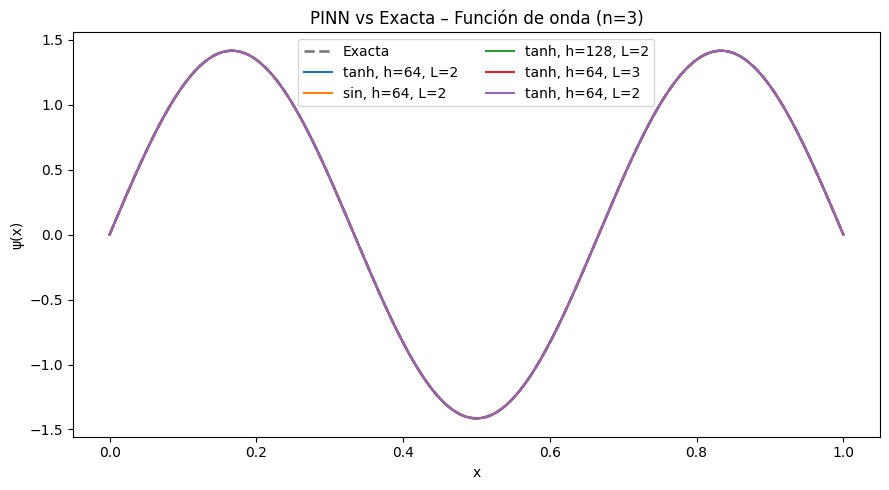

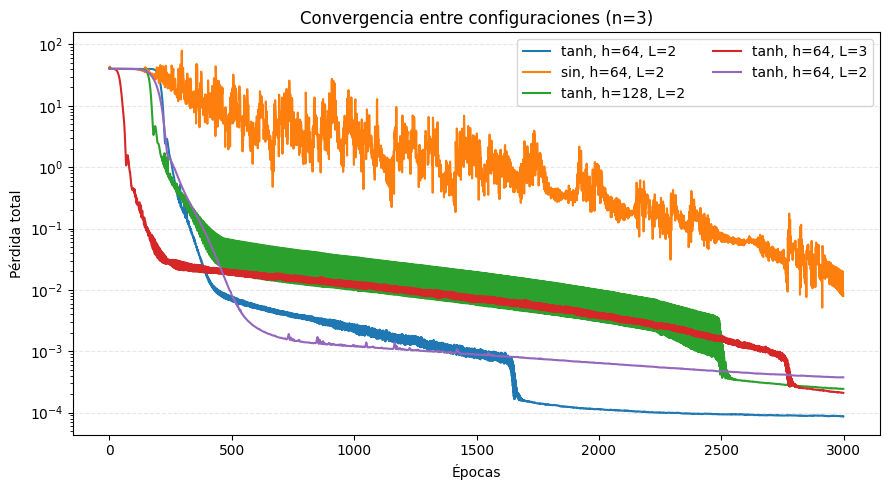

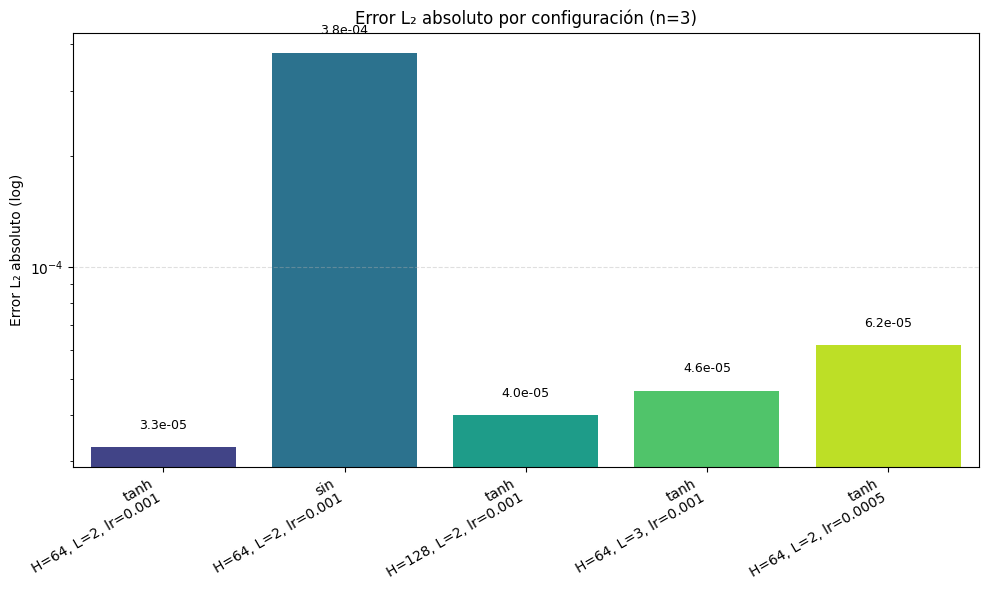

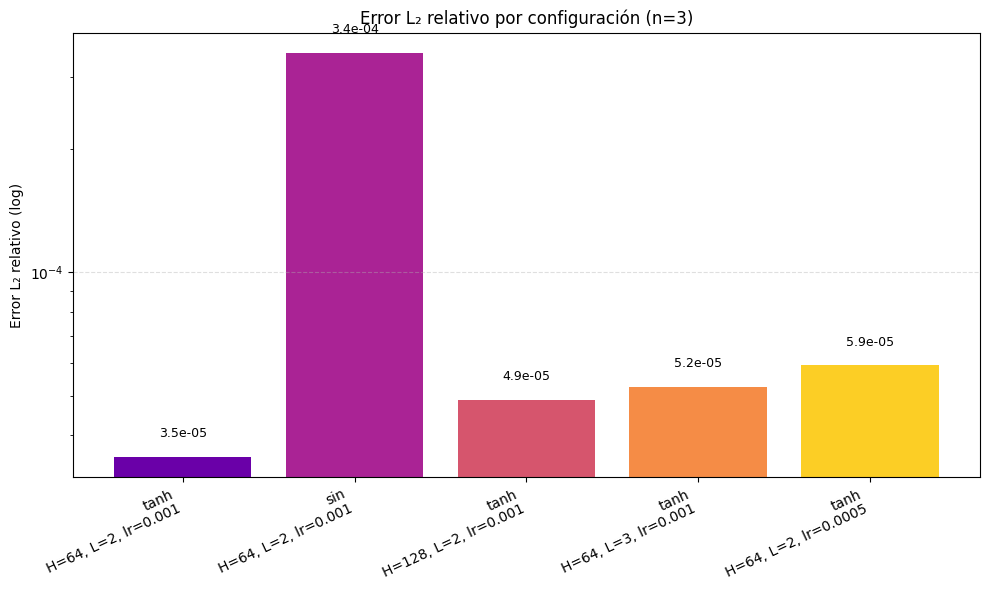

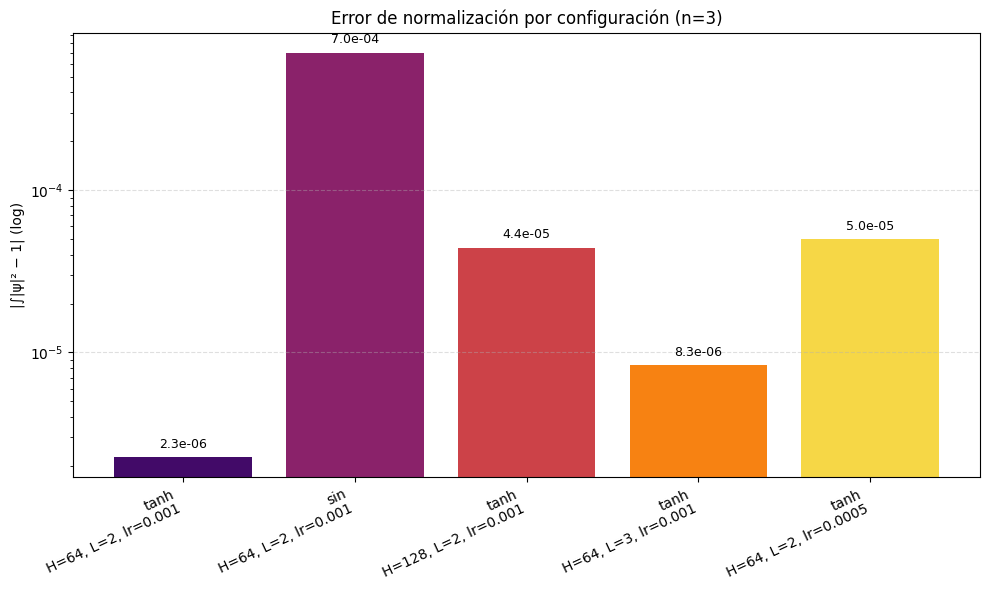

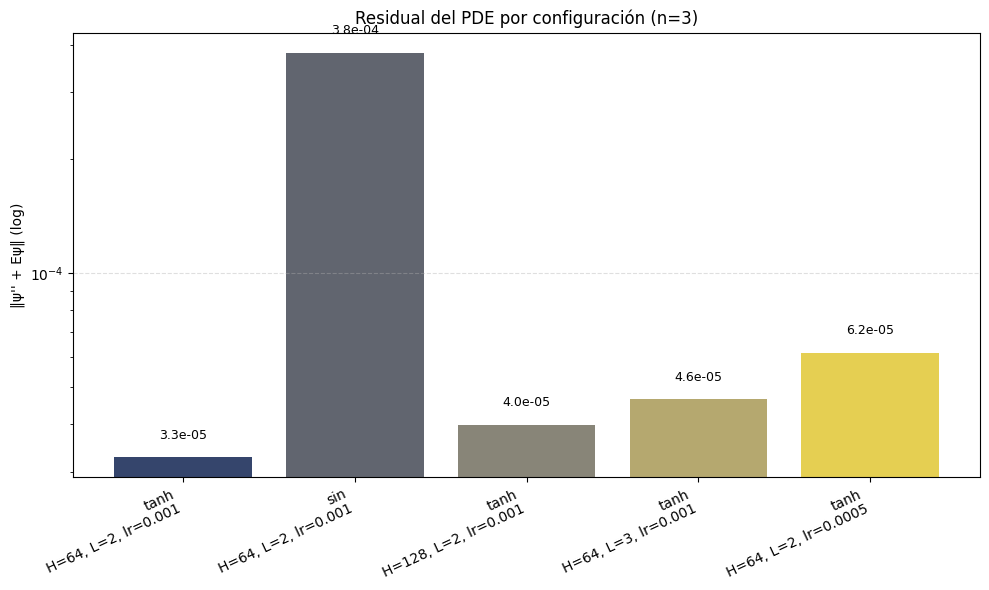

✅ Figuras guardadas correctamente en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/figuras/n3


In [127]:
plot_resultados_PINN(results_n3, BASE_DIR, n=3)


## Configuracion n = 4 

In [130]:
import os, numpy as np, pandas as pd

n_value = 4
results_n4 = []

for cfg in configs:  # ← usa las configuraciones que ya tienes definidas
    print(f"\n🚀 Ejecutando experimento: n={n_value}, act={cfg['activation']}, hidden={cfg['hidden']}, layers={cfg['layers']}, lr={cfg['lr']}")
    
    res = run_experiment(
        n=n_value,
        hidden=cfg["hidden"],
        layers=cfg["layers"],
        activation=cfg["activation"],
        lr=cfg["lr"],
        N_col=2048,
        epochs=3000,
        lam_hi=60.0,
        lam_lo=15.0,
        save_dir=os.path.join(BASE_DIR, "figuras", f"n{n_value}")
    )

    # Guardar ψ(x)
    psi_file = os.path.join(BASE_DIR, "figuras", f"n{n_value}", f"psi_n{n_value}_h{cfg['hidden']}_act{cfg['activation']}.npz")
    np.savez(psi_file, xs=res.get("xs", np.linspace(0,1,2000)), psi_pred=res.get("psi_pred", np.zeros(2000)))
    res["psi_file"] = psi_file

    results_n4.append(res)

print(f"\n✅ Entrenamiento completado para n={n_value}")



🚀 Ejecutando experimento: n=4, act=tanh, hidden=64, layers=2, lr=0.001
[n=4] ep=00001 | LPDE=6.09e+00 | Lnorm=9.96e-01 | ∫|ψ|²≈0.002
[n=4] ep=00600 | LPDE=7.06e-02 | Lnorm=1.04e-05 | ∫|ψ|²≈0.997
[n=4] ep=01200 | LPDE=3.74e-02 | Lnorm=4.87e-06 | ∫|ψ|²≈0.998
[n=4] ep=01800 | LPDE=1.80e-02 | Lnorm=2.12e-06 | ∫|ψ|²≈0.999
[n=4] ep=02400 | LPDE=1.23e-03 | Lnorm=2.08e-08 | ∫|ψ|²≈1.000
[n=4] ep=03000 | LPDE=2.94e-04 | Lnorm=3.20e-12 | ∫|ψ|²≈1.000


/tmp/ipykernel_12170/3552139276.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = float(np.trapz(psi_pred ** 2, xs.squeeze()))
/tmp/ipykernel_12170/3552139276.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  inner = float(np.trapz(psi_pred * psi_exact, xs.squeeze()))



🚀 Ejecutando experimento: n=4, act=sin, hidden=64, layers=2, lr=0.001
[n=4] ep=00001 | LPDE=1.44e-01 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=4] ep=00600 | LPDE=2.71e+00 | Lnorm=1.90e-03 | ∫|ψ|²≈0.956
[n=4] ep=01200 | LPDE=5.41e-01 | Lnorm=2.84e-03 | ∫|ψ|²≈0.947
[n=4] ep=01800 | LPDE=3.88e-01 | Lnorm=2.15e-04 | ∫|ψ|²≈0.985
[n=4] ep=02400 | LPDE=9.68e-02 | Lnorm=7.37e-06 | ∫|ψ|²≈0.997
[n=4] ep=03000 | LPDE=6.76e-03 | Lnorm=1.32e-07 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: n=4, act=tanh, hidden=128, layers=2, lr=0.001
[n=4] ep=00001 | LPDE=2.09e-01 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=4] ep=00600 | LPDE=5.67e-02 | Lnorm=3.61e-07 | ∫|ψ|²≈0.999
[n=4] ep=01200 | LPDE=1.27e-02 | Lnorm=8.71e-10 | ∫|ψ|²≈1.000
[n=4] ep=01800 | LPDE=5.11e-03 | Lnorm=6.17e-08 | ∫|ψ|²≈1.000
[n=4] ep=02400 | LPDE=2.05e-03 | Lnorm=4.11e-08 | ∫|ψ|²≈1.000
[n=4] ep=03000 | LPDE=4.67e-04 | Lnorm=5.60e-09 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: n=4, act=tanh, hidden=64, layers=3, lr=0.001
[n=4] ep=00001 | LPDE=1.05e-01 | Lnorm=1

In [131]:
df_results_n4 = pd.DataFrame([{
    "n": r["n"],
    "activation": r["activation"],
    "hidden": r["hidden"],
    "layers": r["layers"],
    "lr": r["lr"],
    "L2": r["L2"],
    "L2_rel": r["L2_rel"],
    "Integral(ψ²)": r["integral"],
    "NormError": r["norm_error"],
    "PDE_RMS": r["pde_rms"],
    "Inner": r["inner"]
} for r in results_n4])

out_csv = os.path.join(BASE_DIR, "tablas", f"resultados_n{n_value}.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df_results_n4.to_csv(out_csv, index=False)

print(f"✅ CSV guardado en: {out_csv}")
display(df_results_n4.style.set_caption(f"Resultados – n={n_value}"))


✅ CSV guardado en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/tablas/resultados_n4.csv


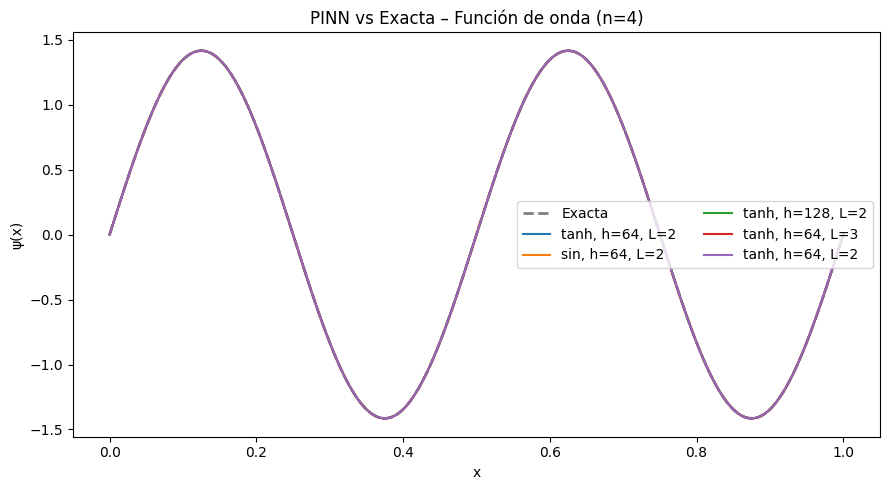

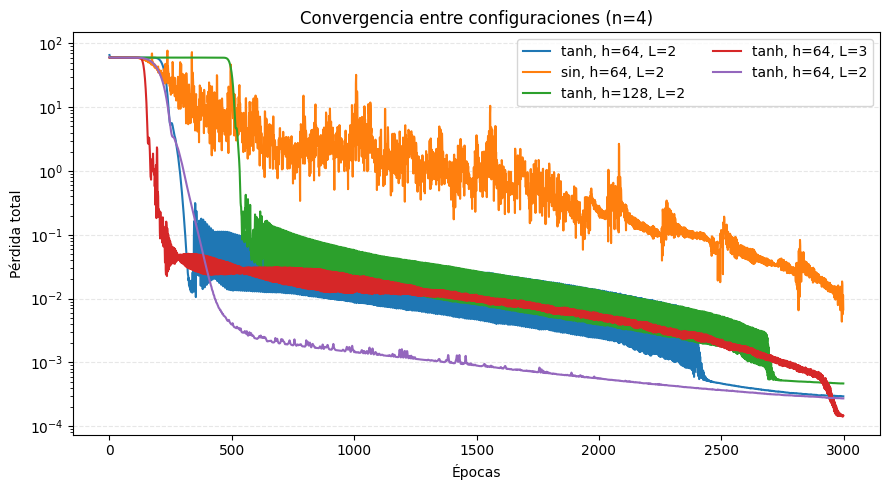

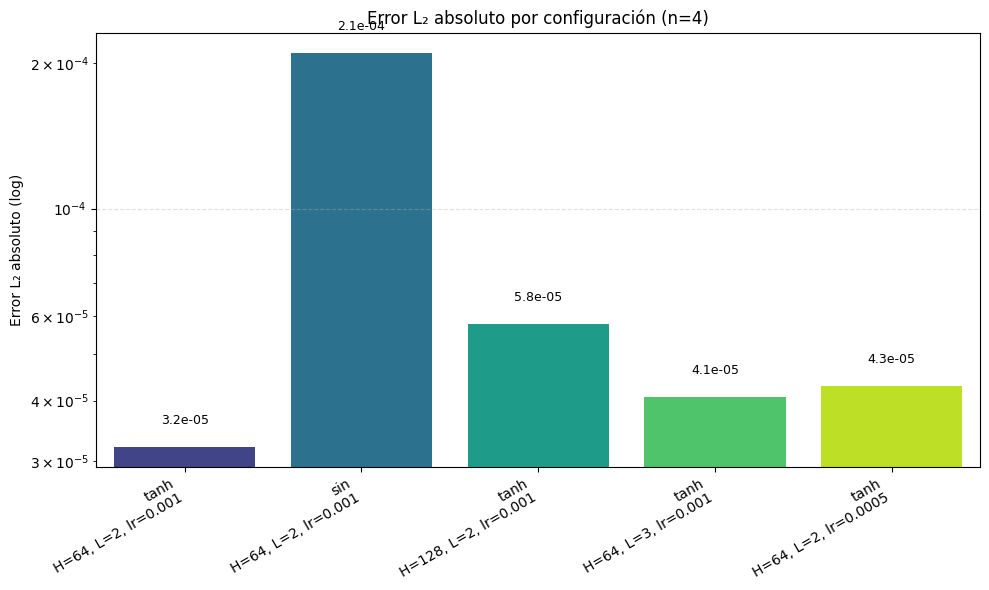

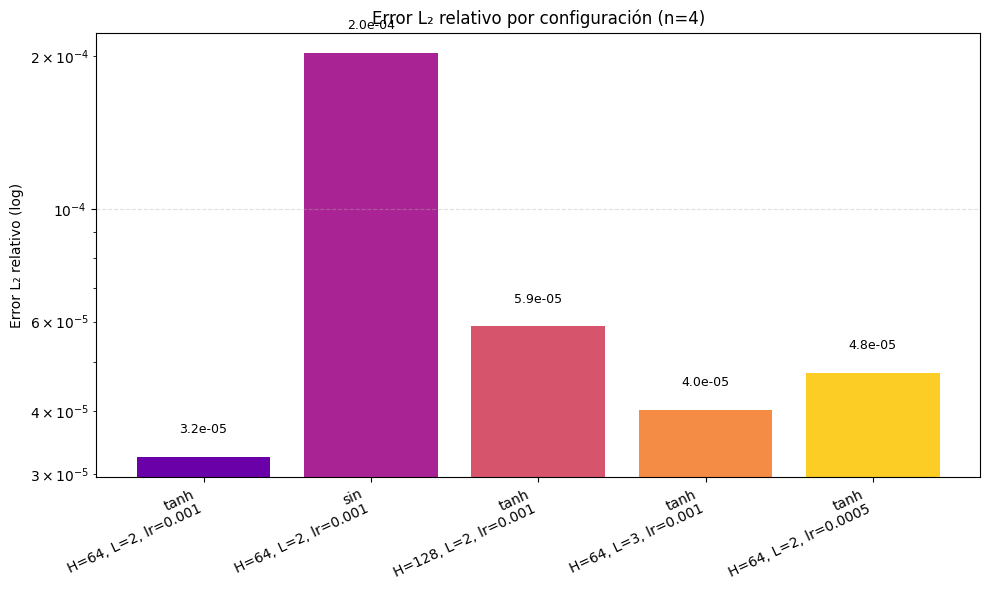

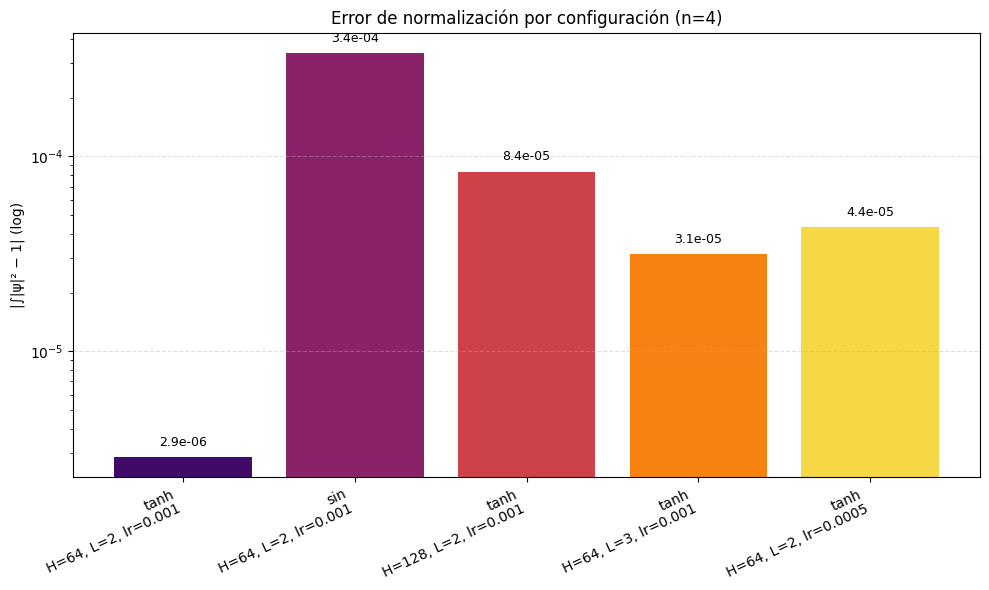

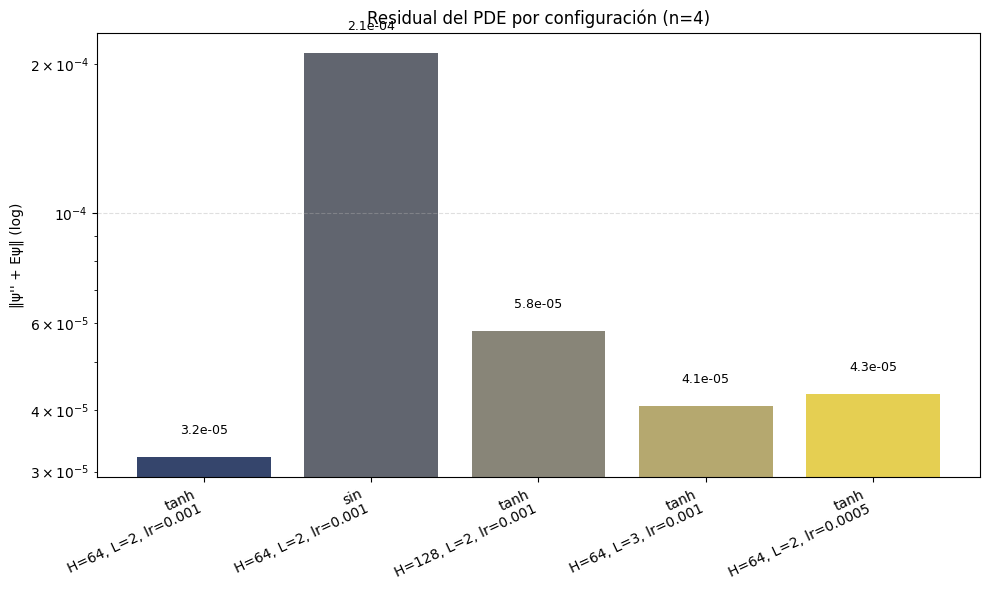

✅ Figuras guardadas correctamente en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/figuras/n4


In [132]:
plot_resultados_PINN(results_n4, BASE_DIR, n=4)


## Configuracion n = 5 



In [133]:
import os, numpy as np, pandas as pd

n_value = 5
results_n5 = []

for cfg in configs:  # ← usa las mismas configuraciones definidas antes
    print(f"\n🚀 Ejecutando experimento: n={n_value}, act={cfg['activation']}, hidden={cfg['hidden']}, layers={cfg['layers']}, lr={cfg['lr']}")

    res = run_experiment(
        n=n_value,
        hidden=cfg["hidden"],
        layers=cfg["layers"],
        activation=cfg["activation"],
        lr=cfg["lr"],
        N_col=2048,
        epochs=6000,
        lam_hi=60.0,
        lam_lo=15.0,
        save_dir=os.path.join(BASE_DIR, "figuras", f"n{n_value}")
    )

    # === Guardar ψ(x) en .npz ===
    psi_file = os.path.join(BASE_DIR, "figuras", f"n{n_value}", f"psi_n{n_value}_h{cfg['hidden']}_act{cfg['activation']}.npz")
    np.savez(psi_file, xs=res.get("xs", np.linspace(0,1,2000)), psi_pred=res.get("psi_pred", np.zeros(2000)))
    res["psi_file"] = psi_file

    results_n5.append(res)

print(f"\n✅ Entrenamiento completado para n={n_value}")



🚀 Ejecutando experimento: n=5, act=tanh, hidden=64, layers=2, lr=0.001
[n=5] ep=00001 | LPDE=2.86e+00 | Lnorm=9.99e-01 | ∫|ψ|²≈0.001
[n=5] ep=01200 | LPDE=2.35e-03 | Lnorm=2.47e-07 | ∫|ψ|²≈1.000
[n=5] ep=02400 | LPDE=1.07e-03 | Lnorm=6.68e-08 | ∫|ψ|²≈1.000
[n=5] ep=03600 | LPDE=5.40e-04 | Lnorm=3.67e-08 | ∫|ψ|²≈1.000
[n=5] ep=04800 | LPDE=1.27e-04 | Lnorm=6.00e-11 | ∫|ψ|²≈1.000
[n=5] ep=06000 | LPDE=1.19e-04 | Lnorm=1.70e-10 | ∫|ψ|²≈1.000


/tmp/ipykernel_12170/3552139276.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = float(np.trapz(psi_pred ** 2, xs.squeeze()))
/tmp/ipykernel_12170/3552139276.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  inner = float(np.trapz(psi_pred * psi_exact, xs.squeeze()))



🚀 Ejecutando experimento: n=5, act=sin, hidden=64, layers=2, lr=0.001
[n=5] ep=00001 | LPDE=2.49e-01 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=5] ep=01200 | LPDE=8.23e+00 | Lnorm=1.87e-02 | ∫|ψ|²≈0.863
[n=5] ep=02400 | LPDE=1.30e+00 | Lnorm=1.20e-02 | ∫|ψ|²≈0.891
[n=5] ep=03600 | LPDE=9.81e-01 | Lnorm=2.81e-04 | ∫|ψ|²≈0.983
[n=5] ep=04800 | LPDE=2.52e-01 | Lnorm=8.29e-06 | ∫|ψ|²≈0.997
[n=5] ep=06000 | LPDE=1.44e-02 | Lnorm=2.29e-07 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: n=5, act=tanh, hidden=128, layers=2, lr=0.001
[n=5] ep=00001 | LPDE=4.96e-01 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=5] ep=01200 | LPDE=1.40e-02 | Lnorm=5.40e-06 | ∫|ψ|²≈0.998
[n=5] ep=02400 | LPDE=7.25e-03 | Lnorm=9.16e-07 | ∫|ψ|²≈0.999
[n=5] ep=03600 | LPDE=3.62e-03 | Lnorm=3.25e-07 | ∫|ψ|²≈0.999
[n=5] ep=04800 | LPDE=1.51e-03 | Lnorm=1.25e-07 | ∫|ψ|²≈1.000
[n=5] ep=06000 | LPDE=2.85e-04 | Lnorm=2.38e-09 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: n=5, act=tanh, hidden=64, layers=3, lr=0.001
[n=5] ep=00001 | LPDE=9.00e-01 | Lnorm=1

In [134]:
df_results_n5 = pd.DataFrame([{
    "n": r["n"],
    "activation": r["activation"],
    "hidden": r["hidden"],
    "layers": r["layers"],
    "lr": r["lr"],
    "L2": r["L2"],
    "L2_rel": r["L2_rel"],
    "Integral(ψ²)": r["integral"],
    "NormError": r["norm_error"],
    "PDE_RMS": r["pde_rms"],
    "Inner": r["inner"]
} for r in results_n5])

out_csv = os.path.join(BASE_DIR, "tablas", f"resultados_n{n_value}.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df_results_n5.to_csv(out_csv, index=False)

print(f"✅ CSV guardado en: {out_csv}")
display(df_results_n5.style.set_caption(f"Resultados – n={n_value}"))


✅ CSV guardado en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/tablas/resultados_n5.csv


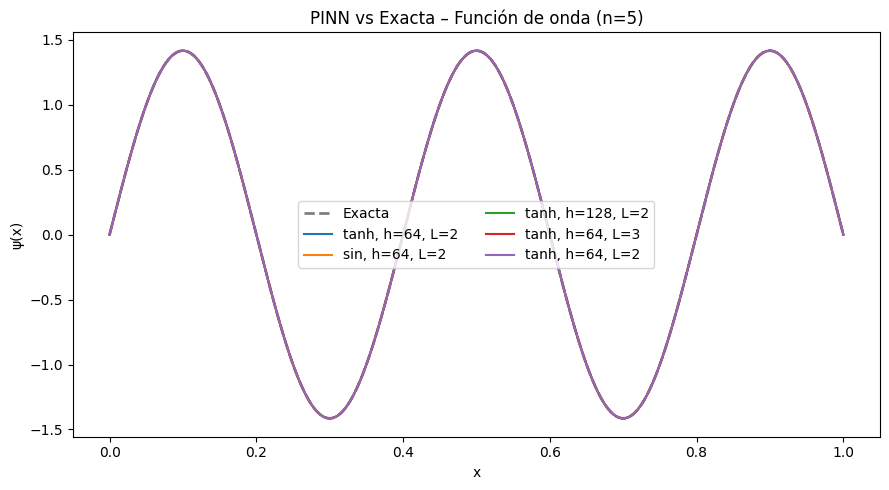

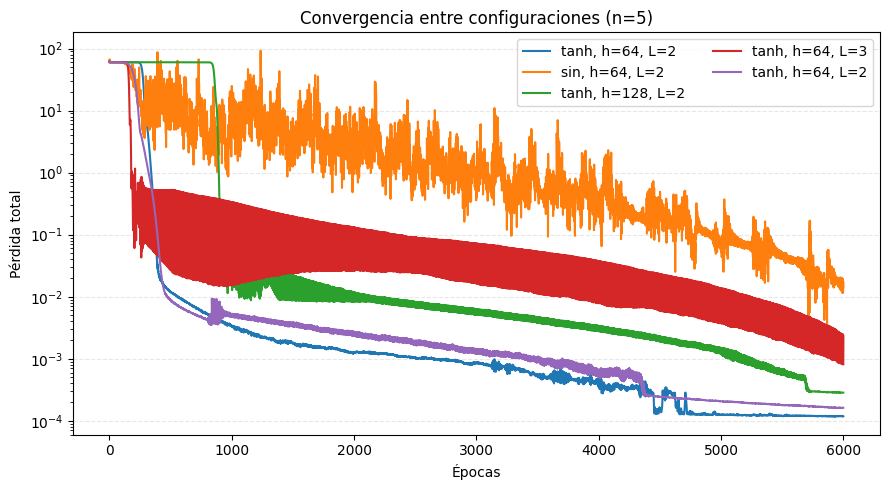

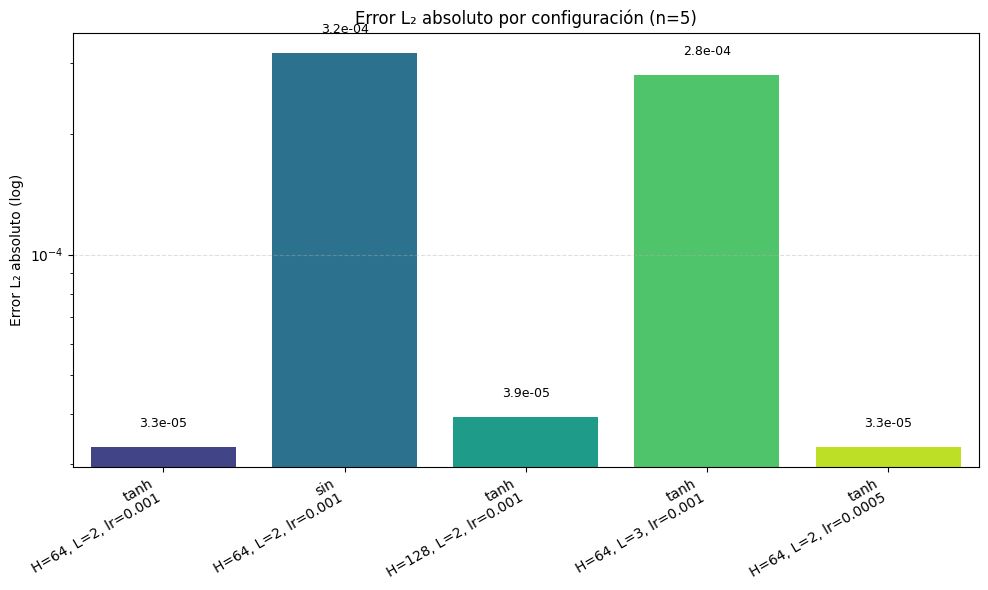

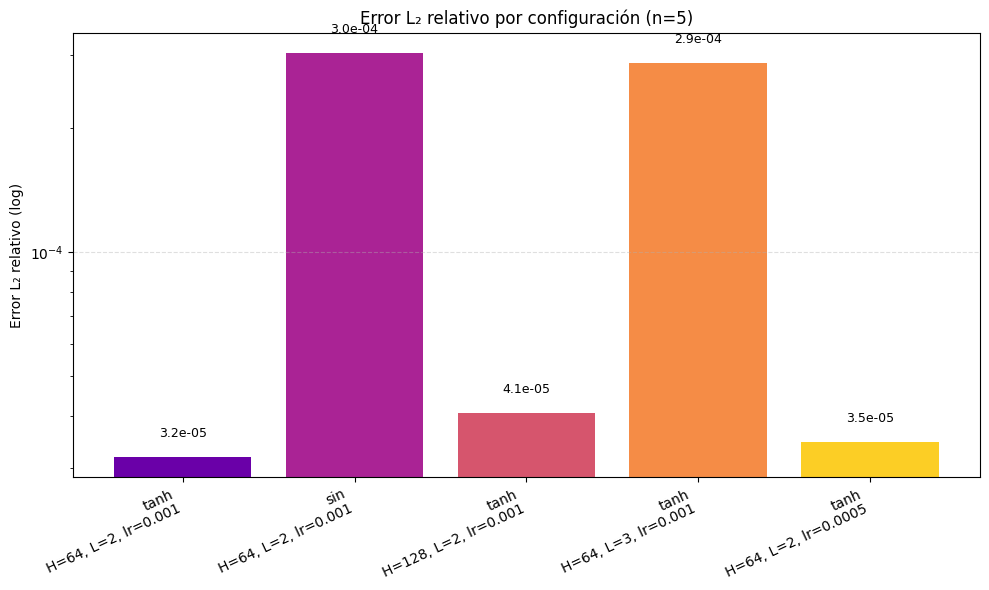

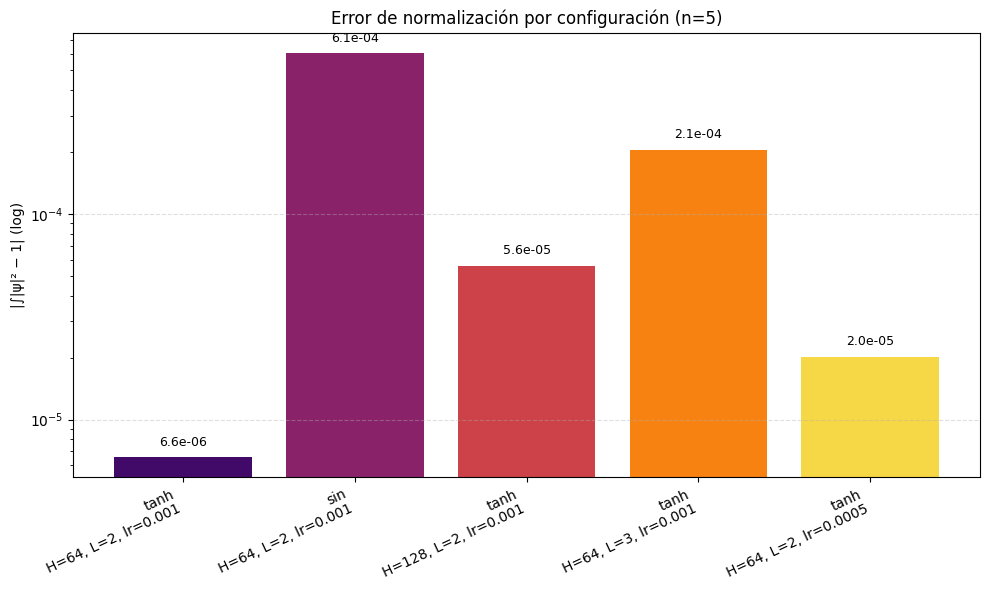

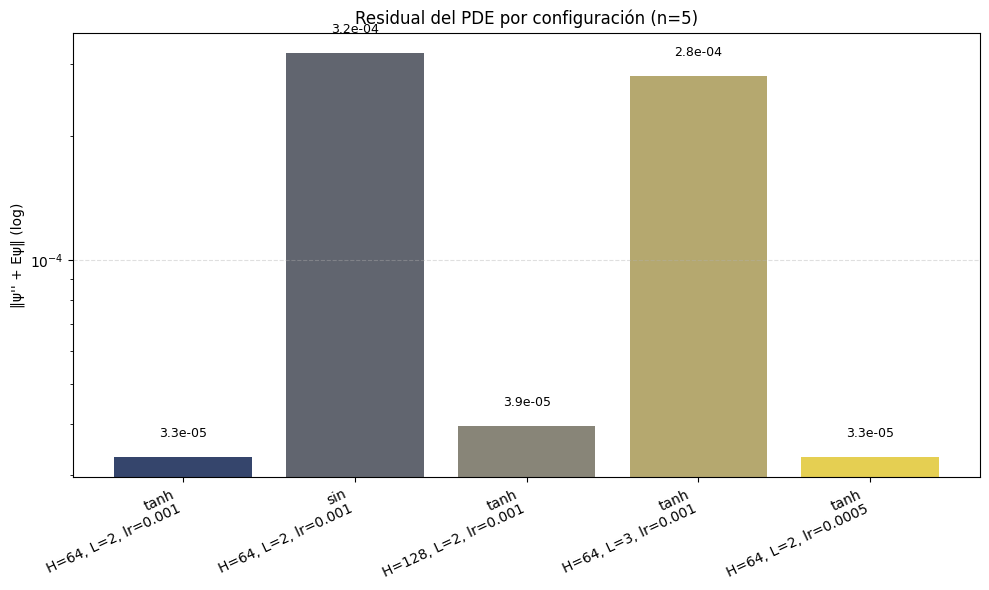

✅ Figuras guardadas correctamente en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/figuras/n5


In [135]:
plot_resultados_PINN(results_n5, BASE_DIR, n=5)


## Configuracion n = 6 

In [136]:
import os, numpy as np, pandas as pd

# === Parámetro principal ===
n_value = 6
results_n6 = []

for cfg in configs:  # usa las mismas configuraciones ya definidas
    print(f"\n🚀 Ejecutando experimento: n={n_value}, act={cfg['activation']}, hidden={cfg['hidden']}, layers={cfg['layers']}, lr={cfg['lr']}")

    res = run_experiment(
        n=n_value,
        hidden=cfg["hidden"],
        layers=cfg["layers"],
        activation=cfg["activation"],
        lr=cfg["lr"],
        N_col=2048,
        epochs=6000,
        lam_hi=60.0,
        lam_lo=15.0,
        save_dir=os.path.join(BASE_DIR, "figuras", f"n{n_value}")
    )

    # === Guardar ψ(x) en .npz ===
    psi_file = os.path.join(BASE_DIR, "figuras", f"n{n_value}", f"psi_n{n_value}_h{cfg['hidden']}_act{cfg['activation']}.npz")
    np.savez(psi_file, xs=res.get("xs", np.linspace(0,1,2000)), psi_pred=res.get("psi_pred", np.zeros(2000)))
    res["psi_file"] = psi_file

    results_n6.append(res)

print(f"\n✅ Entrenamiento completado para n={n_value}")




🚀 Ejecutando experimento: n=6, act=tanh, hidden=64, layers=2, lr=0.001
[n=6] ep=00001 | LPDE=8.80e+00 | Lnorm=9.97e-01 | ∫|ψ|²≈0.001
[n=6] ep=01200 | LPDE=4.62e-03 | Lnorm=1.28e-07 | ∫|ψ|²≈1.000
[n=6] ep=02400 | LPDE=1.12e-03 | Lnorm=5.57e-08 | ∫|ψ|²≈1.000
[n=6] ep=03600 | LPDE=5.65e-04 | Lnorm=7.37e-09 | ∫|ψ|²≈1.000
[n=6] ep=04800 | LPDE=1.96e-04 | Lnorm=3.64e-12 | ∫|ψ|²≈1.000
[n=6] ep=06000 | LPDE=1.46e-04 | Lnorm=6.60e-10 | ∫|ψ|²≈1.000


/tmp/ipykernel_12170/3552139276.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = float(np.trapz(psi_pred ** 2, xs.squeeze()))
/tmp/ipykernel_12170/3552139276.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  inner = float(np.trapz(psi_pred * psi_exact, xs.squeeze()))



🚀 Ejecutando experimento: n=6, act=sin, hidden=64, layers=2, lr=0.001
[n=6] ep=00001 | LPDE=2.02e-01 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=6] ep=01200 | LPDE=2.72e+00 | Lnorm=5.82e-03 | ∫|ψ|²≈0.924
[n=6] ep=02400 | LPDE=4.17e+00 | Lnorm=1.01e-02 | ∫|ψ|²≈0.900
[n=6] ep=03600 | LPDE=5.94e-01 | Lnorm=2.82e-04 | ∫|ψ|²≈0.983
[n=6] ep=04800 | LPDE=8.64e-02 | Lnorm=1.30e-05 | ∫|ψ|²≈0.996
[n=6] ep=06000 | LPDE=1.36e-02 | Lnorm=4.13e-07 | ∫|ψ|²≈0.999

🚀 Ejecutando experimento: n=6, act=tanh, hidden=128, layers=2, lr=0.001
[n=6] ep=00001 | LPDE=8.60e+00 | Lnorm=9.97e-01 | ∫|ψ|²≈0.001
[n=6] ep=01200 | LPDE=4.85e-02 | Lnorm=6.21e-08 | ∫|ψ|²≈1.000
[n=6] ep=02400 | LPDE=1.00e-02 | Lnorm=4.13e-08 | ∫|ψ|²≈1.000
[n=6] ep=03600 | LPDE=1.45e-02 | Lnorm=3.68e-07 | ∫|ψ|²≈1.001
[n=6] ep=04800 | LPDE=4.51e-03 | Lnorm=8.02e-08 | ∫|ψ|²≈1.000
[n=6] ep=06000 | LPDE=1.32e-03 | Lnorm=1.93e-09 | ∫|ψ|²≈1.000

🚀 Ejecutando experimento: n=6, act=tanh, hidden=64, layers=3, lr=0.001
[n=6] ep=00001 | LPDE=1.20e+01 | Lnorm=9

In [137]:
df_results_n6 = pd.DataFrame([{
    "n": r["n"],
    "activation": r["activation"],
    "hidden": r["hidden"],
    "layers": r["layers"],
    "lr": r["lr"],
    "L2": r["L2"],
    "L2_rel": r["L2_rel"],
    "Integral(ψ²)": r["integral"],
    "NormError": r["norm_error"],
    "PDE_RMS": r["pde_rms"],
    "Inner": r["inner"]
} for r in results_n6])

out_csv = os.path.join(BASE_DIR, "tablas", f"resultados_n{n_value}.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df_results_n6.to_csv(out_csv, index=False)

print(f"✅ CSV guardado en: {out_csv}")
display(df_results_n6.style.set_caption(f"Resultados – n={n_value}"))


✅ CSV guardado en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/tablas/resultados_n6.csv


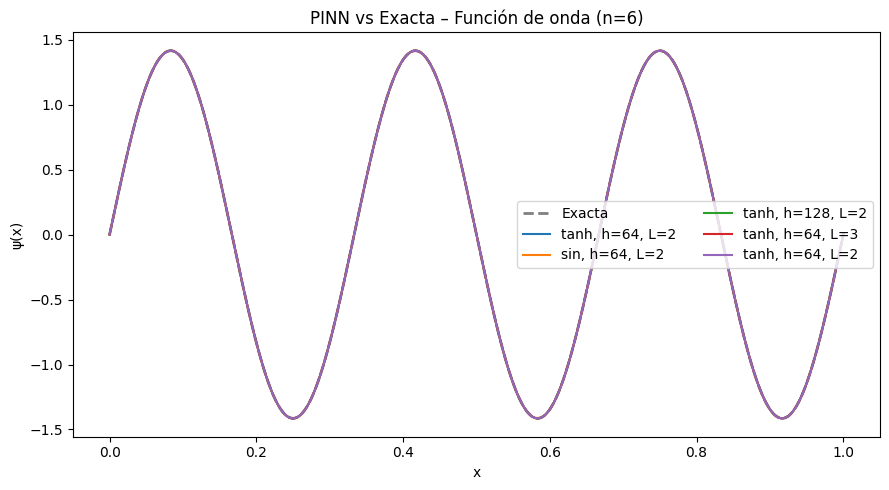

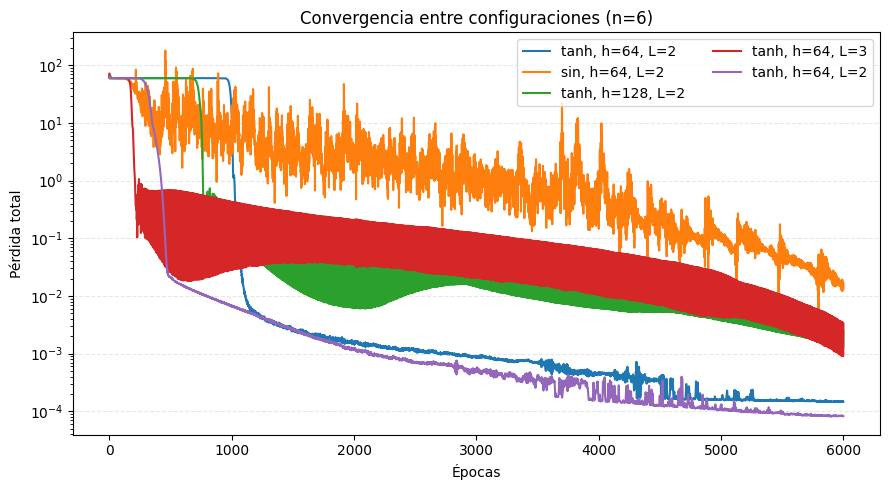

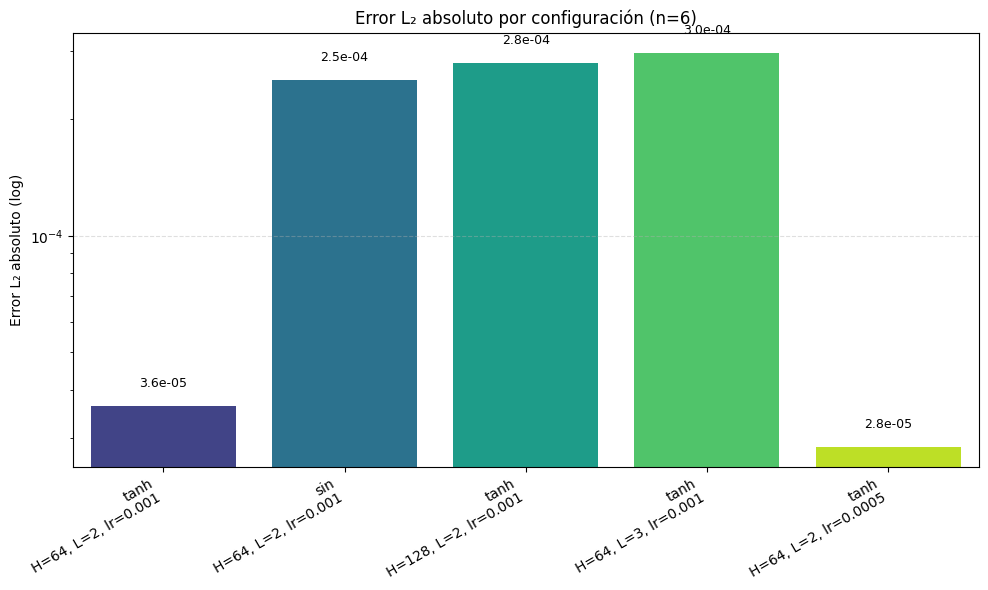

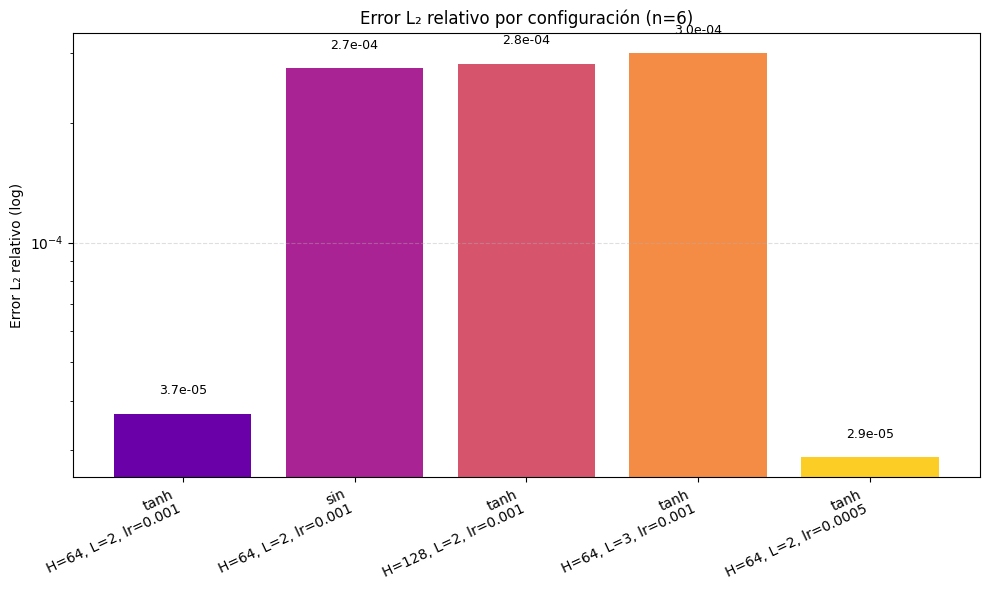

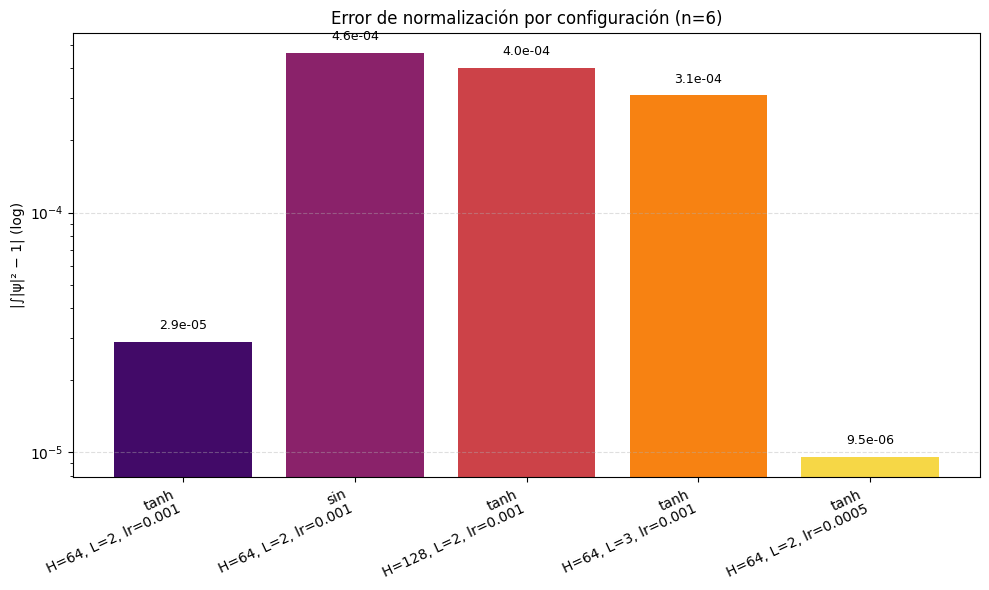

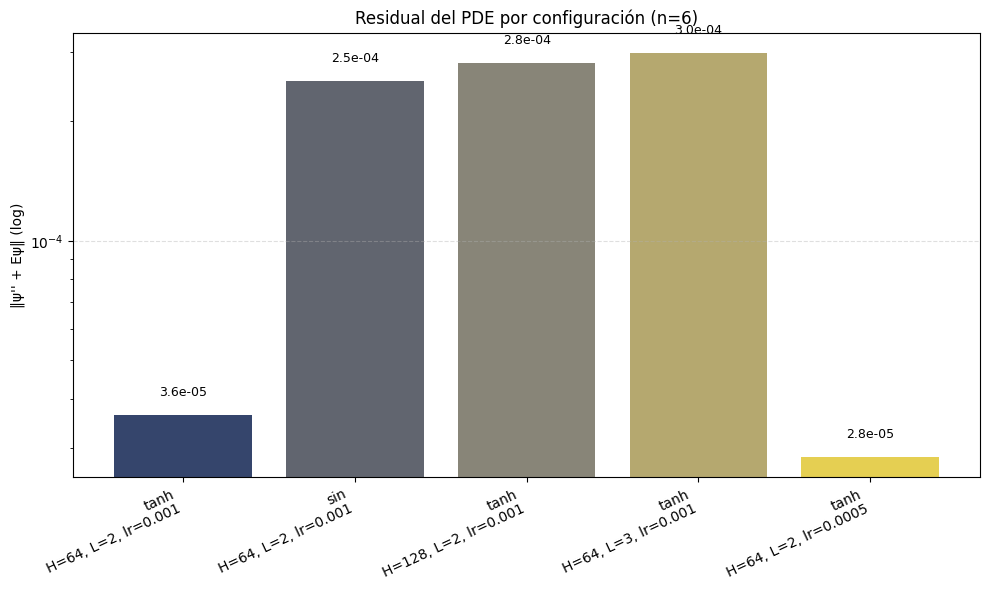

✅ Figuras guardadas correctamente en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/figuras/n6


In [138]:
plot_resultados_PINN(results_n6, BASE_DIR, n=6)


## Configuracion loquita

In [139]:
import os, numpy as np, pandas as pd

n_value = 60
results_n60 = []

configs_n60 = [
    {"activation": "tanh", "hidden": 128, "layers": 3, "lr": 5e-4},
    {"activation": "sin",  "hidden": 128, "layers": 3, "lr": 5e-4},
]

for cfg in configs_n60:
    print(f"\n🚀 Ejecutando experimento: n={n_value}, act={cfg['activation']}, hidden={cfg['hidden']}, layers={cfg['layers']}, lr={cfg['lr']}")

    res = run_experiment(
        n=n_value,
        hidden=cfg["hidden"],
        layers=cfg["layers"],
        activation=cfg["activation"],
        lr=cfg["lr"],
        N_col=4096,
        epochs=15000,
        lam_hi=200.0,
        lam_lo=40.0,
        save_dir=os.path.join(BASE_DIR, "figuras", f"n{n_value}")
    )

    # Guardar ψ(x)
    psi_file = os.path.join(BASE_DIR, "figuras", f"n{n_value}", f"psi_n{n_value}_h{cfg['hidden']}_act{cfg['activation']}.npz")
    np.savez(psi_file, xs=res.get("xs", np.linspace(0,1,2000)), psi_pred=res.get("psi_pred", np.zeros(2000)))
    res["psi_file"] = psi_file
    results_n60.append(res)

print(f"\n✅ Entrenamiento completado para n={n_value}")




🚀 Ejecutando experimento: n=60, act=tanh, hidden=128, layers=3, lr=0.0005
[n=60] ep=00001 | LPDE=9.75e+02 | Lnorm=9.97e-01 | ∫|ψ|²≈0.002
[n=60] ep=03000 | LPDE=1.16e-01 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=60] ep=06000 | LPDE=1.72e-03 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=60] ep=09000 | LPDE=1.19e-03 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=60] ep=12000 | LPDE=2.58e-06 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=60] ep=15000 | LPDE=2.65e-06 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000


/tmp/ipykernel_12170/3552139276.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ = float(np.trapz(psi_pred ** 2, xs.squeeze()))
/tmp/ipykernel_12170/3552139276.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  inner = float(np.trapz(psi_pred * psi_exact, xs.squeeze()))



🚀 Ejecutando experimento: n=60, act=sin, hidden=128, layers=3, lr=0.0005
[n=60] ep=00001 | LPDE=9.39e+01 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=60] ep=03000 | LPDE=3.39e-02 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=60] ep=06000 | LPDE=2.87e-02 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=60] ep=09000 | LPDE=2.94e-02 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=60] ep=12000 | LPDE=3.61e-09 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000
[n=60] ep=15000 | LPDE=3.91e-11 | Lnorm=1.00e+00 | ∫|ψ|²≈0.000

✅ Entrenamiento completado para n=60


In [ ]:
df_n60 = pd.DataFrame([{
    "n": r["n"],
    "activation": r["activation"],
    "hidden": r["hidden"],
    "layers": r["layers"],
    "lr": r["lr"],
    "L2": r["L2"],
    "Integral(ψ²)": r["integral"],
    "NormError": r["norm_error"],
    "PDE_RMS": r["pde_rms"]
} for r in results_n60])

out_csv = os.path.join(BASE_DIR, "tablas", f"resultados_n{n_value}.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df_n60.to_csv(out_csv, index=False)
display(df_n60.style.set_caption(f"Resultados comparativos – n={n_value}"))


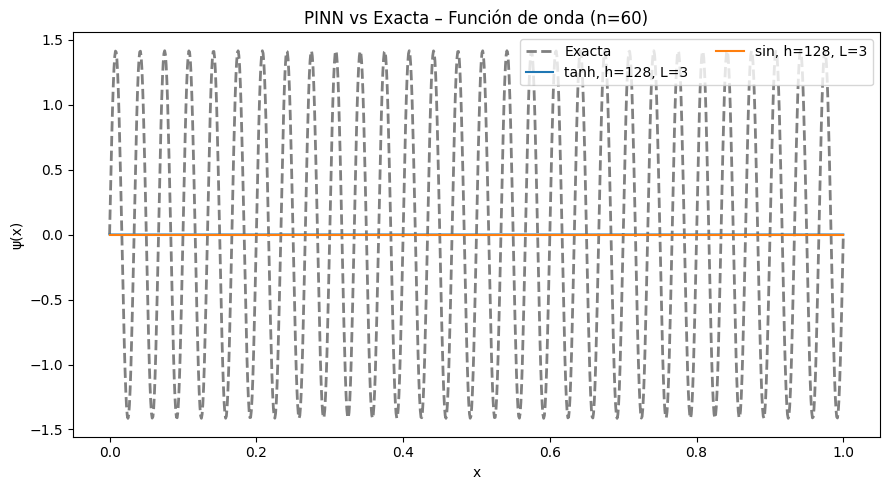

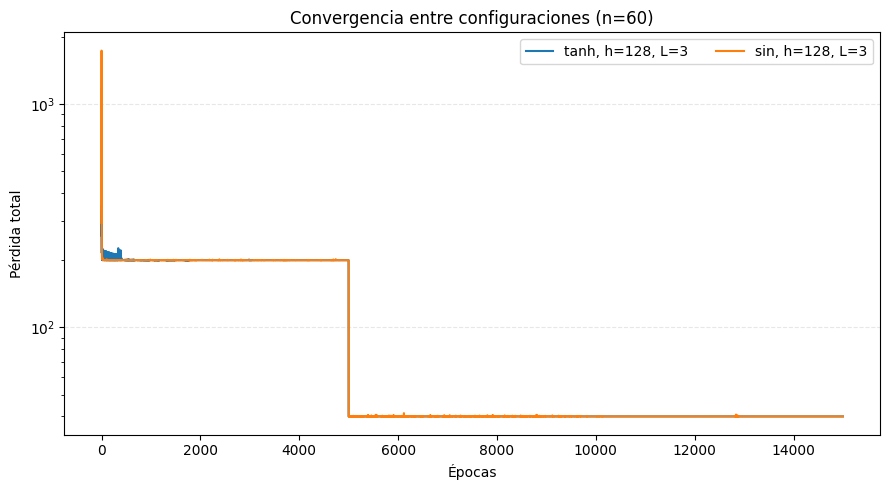

/tmp/ipykernel_12170/3591000258.py:100: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


/tmp/ipykernel_12170/3591000258.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


/tmp/ipykernel_12170/3591000258.py:136: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_12170/3591000258.py:137: MatplotlibDeprecationWarning: The y parameter as float was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use int(y) instead.
  plt.savefig(os.path.join(fig_dir, f"bar_norm_error_n{n}.png"), dpi=200)


ValueError: Image size of 890x1356825914 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 1000x600 with 1 Axes>

/tmp/ipykernel_12170/3591000258.py:154: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


✅ Figuras guardadas correctamente en: /home/david/Schr-dingerPINNsUQValidation/Estudio_Programacion/Errors/figuras/n60


In [140]:
plot_resultados_PINN(results_n60, BASE_DIR, n=60)
